## Controlling Memorability of Face Images

### Warning: This notebook is a combination of many experiments done pasted into one file and is not organized as a product. It is not recommended to run it all at once. This should be used as a reference and review to see some of the directions that were taken.

#### If all ran at once it will most likely take ~40mins

#### A step by step guide may be created in the future

In [1]:
print("Hello World")

Hello World


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from utils.utils_stylegan2 import convert_images_to_uint8

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [4]:
#if cude available set to 'cuda', else, set to 'ref'
impl = 'ref'
gpu = True 

In [5]:
from stylegan2_generator import StyleGan2Generator

### Loading the weights

In [6]:
weights_name = 'ffhq' # face model trained by Nvidia

# instantiating generator network
generator = StyleGan2Generator(weights=weights_name, impl=impl, gpu=gpu)

# loading w average
w_average = np.load('weights/{}_dlatent_avg.npy'.format(weights_name))

Loaded ffhq generator weights!


### Preprocessing functions

In [7]:
import cv2
import PIL
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
def ovalize_new(image):
    faces = detector.detect_faces(image)
    for result in faces:
        x, y, w, h = result['box']
        x1, y1 = x + w, y + h
        image = image[y-75:y1+75, x-75:x1+75]
        break
    mask = np.zeros(image.shape, dtype=np.uint8)
    x,y = image.shape[1], image.shape[0]
    cv2.ellipse(mask, (x//2,y//2), (x//2,y//2),0.0,0.0,360.0,(255,255,255), -1)

    # Bitwise-and for ROI
    ROI = cv2.bitwise_and(image, mask)

    # Crop mask and turn background white
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    x,y,w,h = cv2.boundingRect(mask)
    result = ROI[y:y+h,x:x+w]
    mask = mask[y:y+h,x:x+w]
    result[mask==0] = (255,255,255)
    image = Image.fromarray(result.astype('uint8'), 'RGB')
    fixed_height = 256
    height_percent = (fixed_height / float(image.size[1]))
    width_size = int((float(image.size[0]) * float(height_percent)))
    image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)
    return image

In [8]:
from PIL import Image
def load_image(image_file):
    image_file = Image.fromarray(image_file)
    image_file = image_file.resize((224,224))
    
    return np.array(image_file, dtype=np.uint8)

In [9]:
from PIL import Image
def save_image(image_file,name):
    image_file = Image.fromarray(image_file)
    #image_file = image_file.resize((256,256))
    im1 = image_file.save(name)

### Creating a sample face

In [10]:
# weird bug ?
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

(1, 18, 512)


(-0.5, 1023.5, 1023.5, -0.5)

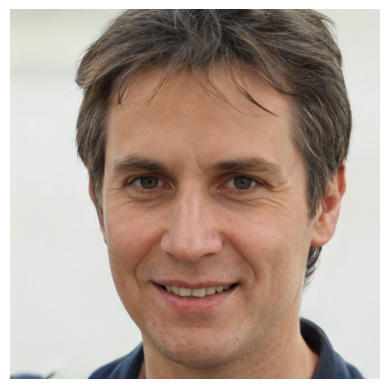

In [11]:
%matplotlib inline
seed = 500
rnd = np.random.RandomState(seed)
z = rnd.randn(1, 512).astype('float32')
#z = np.random.rand(1,512)
dlatents = generator.mapping_network(z)
dlatents = w_average + (dlatents - w_average) * 0.5
print(dlatents.shape)
out = generator.synthesis_network(dlatents)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
##img = load_image(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

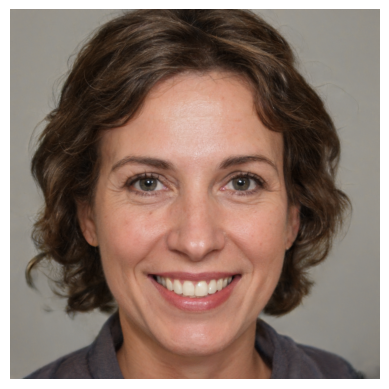

In [12]:
%matplotlib inline
seed = 2000
rnd = np.random.RandomState(seed)
z = rnd.randn(1, 512).astype('float32')
#z = np.random.rand(1,512)
dlatents = generator.mapping_network(z)
dlatents = w_average + (dlatents - w_average) * 0.5
out = generator.synthesis_network(dlatents)
img1= convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img1 = img1.numpy()[0]
#img = load_image(img)
plt.imshow(img1)
plt.axis('off')

## Loading the assessors

In [13]:
import numpy as np
from PIL import Image
from cv2 import resize
import tensorflow as tf
import multiprocessing as mp
import pandas as pd
#import matplotlib.pyplot as plt
import os
#import seaborn as sns
import csv
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from tensorflow.keras.models import Model, Sequential



def euclidean_distance_loss(y_true, y_pred):
    return tf.math.sqrt(tf.math.reduce_sum(tf.math.square(y_pred - y_true), axis=-1))

assessor_1 = tf.keras.models.load_model('assessors/face/resnet/epoch_28.h5', custom_objects={'euclidean_distance_loss': euclidean_distance_loss})
assessor_2 = tf.keras.models.load_model('assessors/face/senet/epoch_19.h5', custom_objects={'euclidean_distance_loss': euclidean_distance_loss})
assessor_3 = tf.keras.models.load_model('assessors/face/vgg/vgg_epoch_18.h5', custom_objects={'euclidean_distance_loss': euclidean_distance_loss})

### A sample for ovalization

1/1 [==============================] - 0s 155ms/step


C:\Users\jason\AppData\Local\Temp\ipykernel_24852\409074531.py:29: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)


(-0.5, 202.5, 255.5, -0.5)

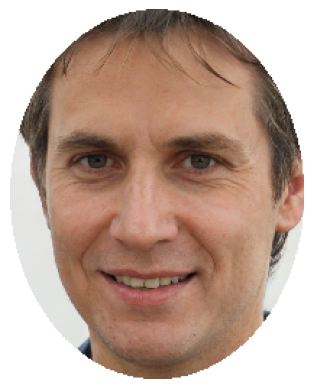

In [14]:
oval = ovalize_new(img)
oval = np.array(oval)
plt.imshow(oval)
plt.axis('off')

1/1 [==============================] - 0s 21ms/step


C:\Users\jason\AppData\Local\Temp\ipykernel_24852\409074531.py:29: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)


(-0.5, 189.5, 255.5, -0.5)

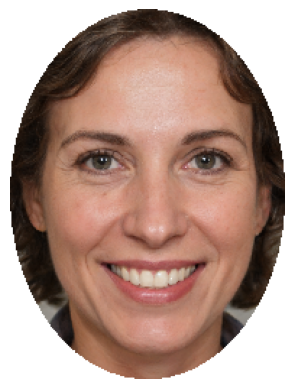

In [15]:
oval = ovalize_new(img1)
oval = np.array(oval)
plt.imshow(oval)
plt.axis('off')

### Getting the memorability scores of a sample face

In [16]:
oval = load_image(oval)
oval = oval.reshape((1,224,224,3))
print(assessor_1.predict(oval))
print(assessor_2.predict(oval))
print(assessor_3.predict(oval))

1/1 [==============================] - 1s 1s/step
[[0.20607191]]
1/1 [==============================] - 2s 2s/step
[[0.17829296]]
1/1 [==============================] - 0s 306ms/step
[[0.25264308]]


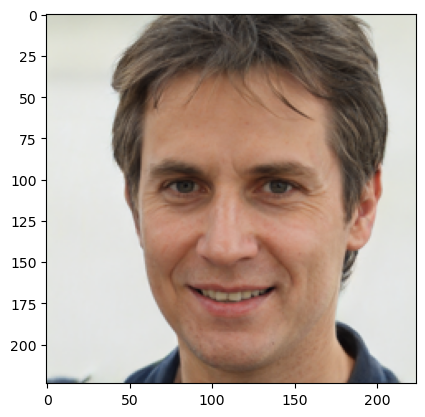

In [17]:
img = load_image(img)
plt.imshow(img)

In [18]:
img = img.reshape((1,224,224,3))
print(assessor_1.predict(img)[0])
print(assessor_2.predict(img)[0])
print(assessor_3.predict(img)[0])

1/1 [==============================] - 0s 129ms/step
[0.3906514]
1/1 [==============================] - 0s 104ms/step
[0.57026696]
1/1 [==============================] - 0s 133ms/step
[0.22155967]


### Loading the memorability values and latent vectors

In [19]:
mems_1 = np.load('misc/mems_resnet.npy')
mems_1_oval = np.load('misc/mems_resnet_oval.npy')
mems_2 = np.load('misc/mems_senet.npy')
mems_2_oval = np.load('misc/mems_senet_oval.npy')
mems_3 = np.load('misc/mems_vgg.npy')
mems_3_oval = np.load('misc/mems_vgg_oval.npy')

lats = np.load('misc/lats_512_style2.npy')

In [20]:
print(mems_1.shape)
print(mems_2.shape)
print(type(mems_1))
print(type(mems_2))
print(mems_1)
print(mems_2)
print(mems_1[0])
print(mems_2[0])

(100000, 1)
(100000, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[0.4028904 ]
 [0.36459887]
 [0.5170452 ]
 ...
 [0.53544265]
 [0.3773541 ]
 [0.47873008]]
[[0.45325252]
 [0.56094015]
 [0.5694777 ]
 ...
 [0.74614584]
 [0.91103745]
 [0.6103509 ]]
[0.4028904]
[0.45325252]


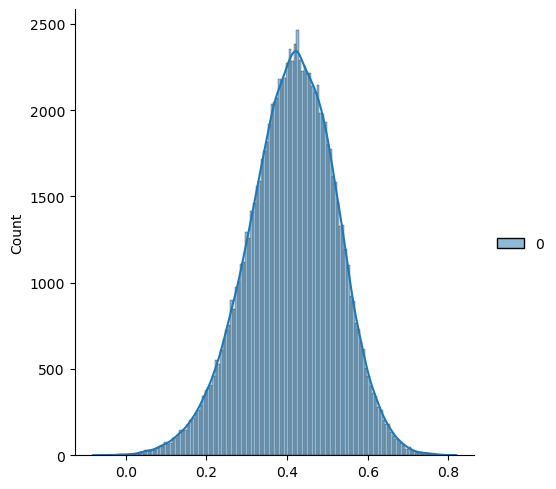

In [21]:
import seaborn as sns

sns.displot(mems_1,kde = True)

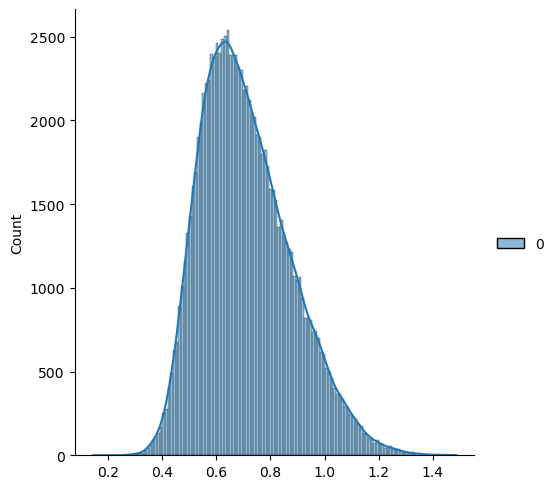

In [22]:
sns.displot(mems_2,kde = True)

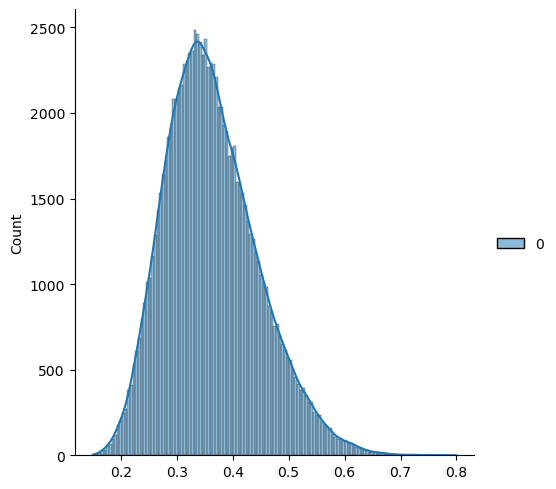

In [23]:
sns.displot(mems_3,kde = True)

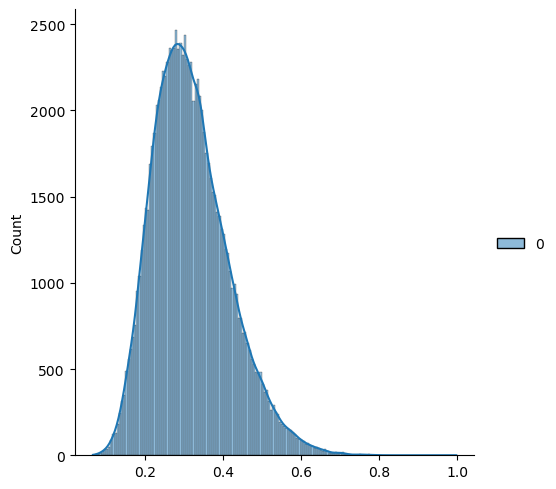

In [24]:
sns.displot(mems_1_oval,kde = True)

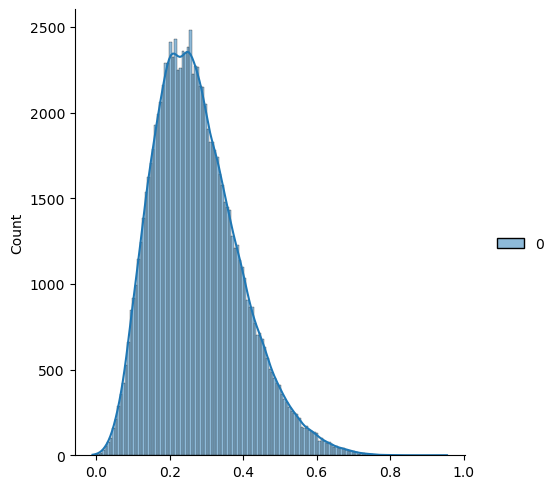

In [25]:
sns.displot(mems_2_oval,kde = True)

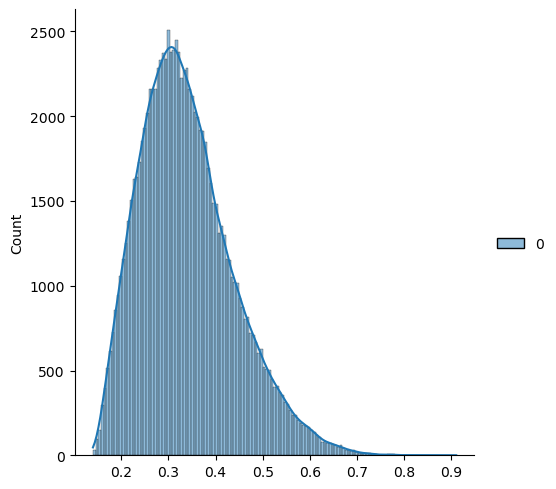

In [26]:
sns.displot(mems_3_oval,kde = True)

### Saving and loading the extended latent vector of each image

In [27]:
mems_aug_style2 = [(w_average + (generator.mapping_network(x) - w_average) * 0.5) for x in lats]

In [28]:
np.save('misc/lats_aug_style2.npy', mems_aug_style2)

In [29]:
mems_aug_style2 = np.load('misc/lats_aug_style2.npy')

In [30]:
print(mems_aug_style2.shape)

(100000, 1, 18, 512)


### Getting the rank correlation of the oval and square-shaped memorability scores

In [31]:
from scipy.stats import rankdata

rank_1 = rankdata(mems_1)
rank_2 = rankdata(mems_2)
rank_3 = rankdata(mems_3)
rank_1_oval = rankdata(mems_1_oval)
rank_2_oval = rankdata(mems_2_oval)
rank_3_oval = rankdata(mems_3_oval)

In [32]:
from scipy import stats

sp1 = stats.spearmanr(rank_1, rank_1_oval)
sp2 = stats.spearmanr(rank_2, rank_2_oval)
sp3 = stats.spearmanr(rank_3, rank_3_oval)
kt1 = stats.kendalltau(rank_1, rank_1_oval)
kt2 = stats.kendalltau(rank_2, rank_2_oval)
kt3 = stats.kendalltau(rank_3, rank_3_oval)

print("SP and kt for the first assessor: ")
print(sp1)
print(kt1)
print("SP and kt for the second assessor: ")
print(sp2)
print(kt2)
print("SP and kt for the third assessor: ")
print(sp3)
print(kt3)

SP and kt for the first assessor: 
SignificanceResult(statistic=0.23913553336200516, pvalue=0.0)
SignificanceResult(statistic=0.16066774256245728, pvalue=0.0)
SP and kt for the second assessor: 
SignificanceResult(statistic=0.6217577943196705, pvalue=0.0)
SignificanceResult(statistic=0.44192398487816204, pvalue=0.0)
SP and kt for the third assessor: 
SignificanceResult(statistic=0.6562532862594502, pvalue=0.0)
SignificanceResult(statistic=0.47204200348886305, pvalue=0.0)


### Labeling the images to highly-memorable and low memorable faces

In [33]:
#You can use mean or median

mean_1 = np.mean(mems_1) 
mean_2 = np.mean(mems_2)
mean_3 = np.mean(mems_3)
mean_1_oval = np.mean(mems_1_oval)
mean_2_oval = np.mean(mems_2_oval)
mean_3_oval = np.mean(mems_3_oval)

In [34]:
y_1 = np.ones_like(mems_1)
y_1[mems_1<mean_1] = 0
y_2 = np.ones_like(mems_2)
y_2[mems_2<mean_2] = 0
y_3 = np.ones_like(mems_3)
y_3[mems_3<mean_3] = 0
y_1_oval = np.ones_like(mems_1_oval)
y_1_oval[mems_1_oval<mean_1_oval] = 0
y_2_oval = np.ones_like(mems_2_oval)
y_2_oval[mems_2_oval<mean_2_oval] = 0
y_3_oval = np.ones_like(mems_3_oval)
y_3_oval[mems_3_oval<mean_3_oval] = 0

In [35]:
lats = lats.reshape((100000,512))
print(lats.shape)

(100000, 512)


In [36]:
mems_aug_style2 = np.array([np.ravel(x) for x in mems_aug_style2])
print(mems_aug_style2.shape)

(100000, 9216)


### Layer-wise analysis

In [37]:
work = mems_aug_style2[:10000]
work_mem = mems_2[:10000]
work_mem_oval = mems_2_oval[:2500]

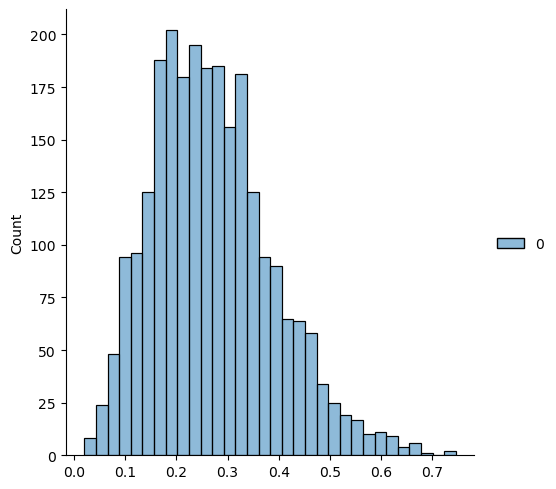

In [38]:
sns.displot(work_mem_oval)

In [39]:
#Linear-shifting of the memorability to make the mean and std equal to the 10k us face database for square-shaped faces

def calc_mem(x):
    a = (x-0.71059185)*(0.15/0.16659632) + 0.4
    if a>1:
        a = 1
    if a<0:
        a= 0
    return a

In [40]:
#Linear-shifting of the memorability to make the mean and std equal to the 10k us face database for oval-shaped faces

def calc_mem_ov(x):
    a = (x-0.273)*(0.138/0.117) + 0.38
    if a>1:
        a = 1
    if a<0:
        a= 0
    return a

In [41]:
work_mem = np.array([calc_mem(x) for x in work_mem])
work_mem = np.ravel(work_mem)
work_mem = work_mem.astype('float32')

C:\Users\jason\AppData\Local\Temp\ipykernel_24852\377114898.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  work_mem = np.array([calc_mem(x) for x in work_mem])


In [42]:
work_mem_oval = np.array([calc_mem_ov(x) for x in work_mem_oval])
work_mem_oval = np.ravel(work_mem_oval)
work_mem_oval = work_mem_oval.astype('float32')

In [43]:
#Loading the separating hyperplane based on SENET assessor
import numpy as np

w_sq = np.load('misc/w_aug_ass2_sq_mean.npy')
test_w_sq = np.load('misc/test_w_aug_ass2_sq_mean.npy')
test_notmean_w_sq = np.load('misc/test_w_aug_ass2_sq.npy')
w_ov = np.load('misc/w_aug_ass2_ov_mean.npy')

w_sq = w_sq/np.linalg.norm(w_sq)
test_w_sq = test_w_sq/np.linalg.norm(test_w_sq)
test_notmean_w_sq = test_notmean_w_sq/np.linalg.norm(test_notmean_w_sq)
w_ov = w_ov/np.linalg.norm(w_ov)

In [44]:
test_notmean_w_sq = test_notmean_w_sq.reshape((18,512))
#print(test_notmean_w_sq[0,12,:]==test_notmean_w_sq[0,5,:])
print(test_notmean_w_sq[0])

[ 9.46253704e-03 -2.09857688e-02 -2.94166523e-03 -4.29288551e-03
 -1.06960044e-02 -1.12299748e-03 -8.52527509e-03  1.07801731e-02
  8.75853302e-03 -2.58311749e-03  1.16526900e-02 -1.89061841e-02
 -6.23021358e-03  1.07162631e-03  6.49001451e-03 -2.42353818e-04
 -1.42649767e-02 -2.64492813e-02 -1.88112800e-02  1.00420497e-03
  7.83286309e-03 -4.40484707e-03 -1.08090260e-02 -1.13999614e-03
  1.31020169e-02  1.14194618e-02  4.77338852e-03  9.26544847e-03
  7.54046980e-03 -1.03352255e-02 -6.90065293e-03  1.56178002e-02
  9.41936051e-03  1.42391424e-02 -4.13742747e-03  6.82820074e-03
 -8.17742587e-03 -5.92733934e-03  6.19194888e-04  7.49803361e-03
 -9.88902096e-03 -9.78094049e-03  8.34503479e-03  2.82213761e-03
 -1.62676749e-03  1.37972736e-02  2.11908550e-02 -7.41339717e-03
 -5.70894175e-03 -2.21328976e-03 -1.12548697e-02 -7.75082558e-04
  7.94858725e-03  1.43456050e-03 -1.17619378e-02 -1.84254775e-02
  1.01766753e-02  8.64435023e-03  3.78147347e-03  1.20121077e-02
  9.63704838e-03  1.81333

In [45]:
(1, 18, 512)
print(test_notmean_w_sq[0][0])
print(test_notmean_w_sq[1][0])
print(test_notmean_w_sq[2][0])

print(test_notmean_w_sq[0][1])
print(test_notmean_w_sq[1][1])
print(test_notmean_w_sq[2][1])

print(test_notmean_w_sq[0][2])
print(test_notmean_w_sq[1][2])
print(test_notmean_w_sq[2][2])

print(test_notmean_w_sq[0][3])
print(test_notmean_w_sq[1][3])
print(test_notmean_w_sq[2][3])

0.009462537039054362
0.009462537039054362
0.009462537039054362
-0.020985768823501984
-0.020985768823501984
-0.020985768823501984
-0.0029416652346850414
-0.0029416652346850414
-0.0029416652346850414
-0.004292885508893386
-0.004292885508893386
-0.004292885508893386


1/1 [==============================] - 1s 884ms/step
[0.31675932]


(-0.5, 1023.5, 1023.5, -0.5)

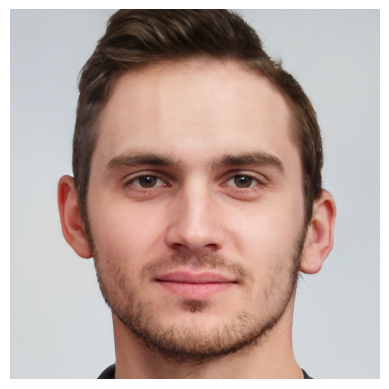

In [46]:
%matplotlib inline
j = 1  #j is the layer
x = work[505].copy()
x[512*j:(j+1)*512] = x[512*j:(j+1)*512] -220* w_sq[512*j:(j+1)*512]
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
ov = load_image(img)
ov = ov.reshape((1,224,224,3))

x = assessor_2.predict(ov)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

1/1 [==============================] - 0s 32ms/step


C:\Users\jason\AppData\Local\Temp\ipykernel_24852\409074531.py:29: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)


1/1 [==============================] - 0s 191ms/step
[0.2463128]


(-0.5, 208.5, 255.5, -0.5)

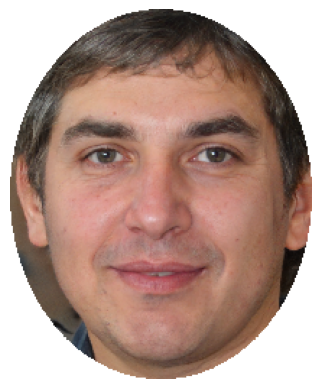

In [47]:
j = 1
x = work[73].copy()
x[512*j:(j+1)*512] = x[512*j:(j+1)*512] -140* w_ov[512*j:(j+1)*512]
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
ov = load_image(oval)
ov = ov.reshape((1,224,224,3))

x = assessor_2.predict(ov)[0]
print(calc_mem_ov(x))
plt.imshow(oval)
plt.axis('off')

### Loading diff layers

In [48]:
sq_layer_2_neg_3 = np.load('misc/sq_layer_2_neg_3.npy')
sq_layer_2_neg_2 = np.load('misc/sq_layer_2_neg_2.npy')
sq_layer_2_neg_1 = np.load('misc/sq_layer_2_neg_1.npy')
sq_layer_2_pos_1 = np.load('misc/sq_layer_2_pos_1.npy')
sq_layer_2_pos_2 = np.load('misc/sq_layer_2_pos_2.npy')
sq_layer_2_pos_3 = np.load('misc/sq_layer_2_pos_3.npy')

In [49]:
sq_layer_2_neg_3 = np.array([calc_mem(x) for x in sq_layer_2_neg_3],dtype='float32')
sq_layer_2_neg_2 = np.array([calc_mem(x) for x in sq_layer_2_neg_2],dtype='float32')
sq_layer_2_neg_1 = np.array([calc_mem(x) for x in sq_layer_2_neg_1],dtype='float32')
sq_layer_2_pos_1 = np.array([calc_mem(x) for x in sq_layer_2_pos_1],dtype='float32')
sq_layer_2_pos_2 = np.array([calc_mem(x) for x in sq_layer_2_pos_2],dtype='float32')
sq_layer_2_pos_3 = np.array([calc_mem(x) for x in sq_layer_2_pos_3],dtype='float32')

sq_layer_2_neg_3 = np.ravel(sq_layer_2_neg_3)
sq_layer_2_neg_2 = np.ravel(sq_layer_2_neg_2)
sq_layer_2_neg_1 = np.ravel(sq_layer_2_neg_1)
sq_layer_2_pos_1 = np.ravel(sq_layer_2_pos_3)
sq_layer_2_pos_2 = np.ravel(sq_layer_2_pos_3)
sq_layer_2_pos_3 = np.ravel(sq_layer_2_pos_3)

C:\Users\jason\AppData\Local\Temp\ipykernel_24852\1197787561.py:1: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  sq_layer_2_neg_3 = np.array([calc_mem(x) for x in sq_layer_2_neg_3],dtype='float32')
C:\Users\jason\AppData\Local\Temp\ipykernel_24852\1197787561.py:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  sq_layer_2_neg_2 = np.array([calc_mem(x) for x in sq_layer_2_neg_2],dtype='float32')
C:\Users\jason\AppData\Local\Temp\ipykernel_24852\1197787561.py:3: DeprecationWarning: setting an array element wi

In [50]:
mean_neg_3 = np.mean(sq_layer_2_neg_3)
mean_neg_2 = np.mean(sq_layer_2_neg_2)
mean_neg_1 = np.mean(sq_layer_2_neg_1)
mean_org = np.mean(work_mem)
mean_pos_1 = np.mean(sq_layer_2_pos_1)
mean_pos_2 = np.mean(sq_layer_2_pos_2)
mean_pos_3 = np.mean(sq_layer_2_pos_3)

In [51]:
sq_layer_8_neg_3 = np.load('misc/sq_layer_8_neg_3.npy')
sq_layer_8_neg_2 = np.load('misc/sq_layer_8_neg_2.npy')
sq_layer_8_neg_1 = np.load('misc/sq_layer_8_neg_1.npy')
sq_layer_8_pos_1 = np.load('misc/sq_layer_8_pos_1.npy')
sq_layer_8_pos_2 = np.load('misc/sq_layer_8_pos_2.npy')
sq_layer_8_pos_3 = np.load('misc/sq_layer_8_pos_3.npy')

### Finding seperating hyperplanes

Non-oval Face - Assessor 1 - 18 * 512

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_1, test_size=0.1, random_state=42)

In [53]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

c:\Users\jason\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


In [54]:
from sklearn import metrics

pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

Accuracy: 0.7927


In [55]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

Accuracy: 0.7981777777777778


In [56]:
w = clf.coef_[0]
np.save('misc/w_aug_ass1_sq.npy', w)

Non-oval Face - Assessor 2 - 18 * 512

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_2, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

c:\Users\jason\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


Accuracy: 0.8316
[[4677  813]
 [ 871 3639]]


<Axes: >

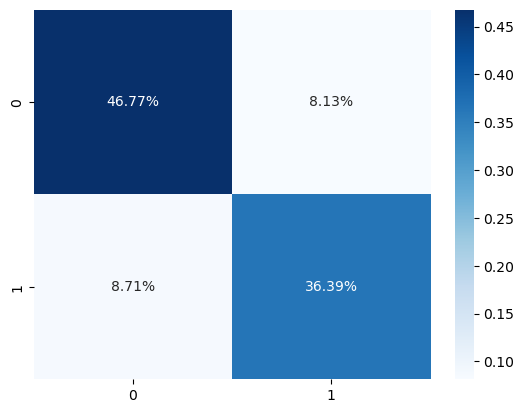

In [58]:
from sklearn.metrics import confusion_matrix

pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8423222222222222
[[42983  6605]
 [ 7586 32826]]


<Axes: >

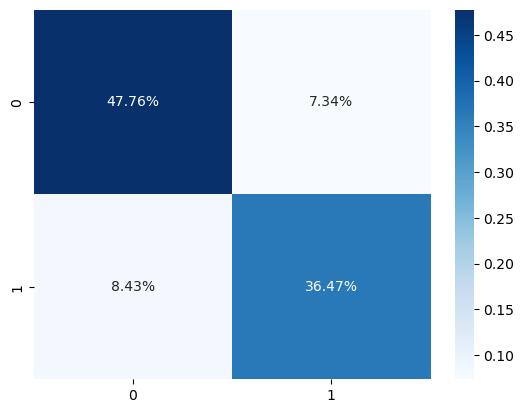

In [59]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [60]:
w = clf.coef_[0]
np.save('misc/w_aug_ass2_sq.npy', w)

Non-oval Face - Assessor 3 - 18 * 512

In [61]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_3, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

c:\Users\jason\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


Accuracy: 0.8069
[[4514  845]
 [1086 3555]]


<Axes: >

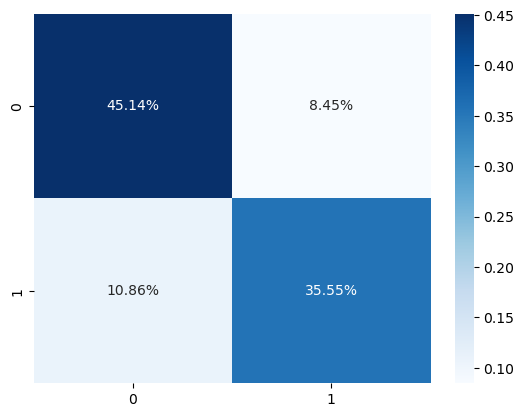

In [62]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8149666666666666
[[41312  7617]
 [ 9036 32035]]


<Axes: >

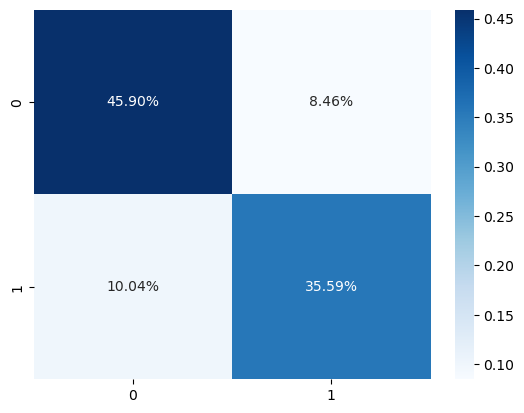

In [63]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [64]:
w = clf.coef_[0]
np.save('misc/w_aug_ass3_sq.npy', w)

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_3_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

c:\Users\jason\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Accuracy: 0.697
[[4157 1313]
 [1717 2813]]


<Axes: >

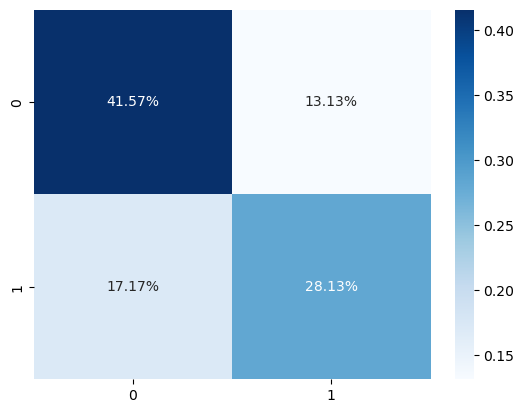

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns


pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Non-oval Face - Assessor 1 - 1 * 512

In [67]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_1, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

c:\Users\jason\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Accuracy: 0.683
[[3179 1631]
 [1539 3651]]


<Axes: >

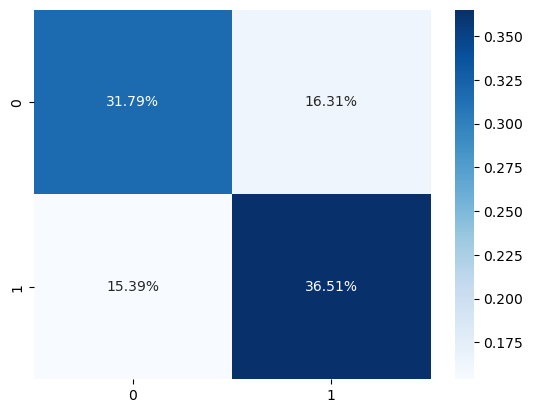

In [68]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.6959222222222222
[[29253 14247]
 [13120 33380]]


<Axes: >

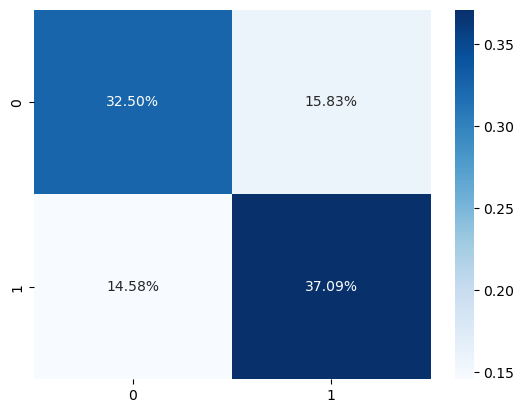

In [69]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [70]:
mean_1 = np.median(mems_1)
mean_2 = np.median(mems_2)
mean_3 = np.median(mems_3)

y_1 = np.ones_like(mems_1)
y_1[mems_1<mean_1] = 0
y_2 = np.ones_like(mems_2)
y_2[mems_2<mean_2] = 0
y_3 = np.ones_like(mems_3)
y_3[mems_3<mean_3] = 0

### Mean instead of median

In [71]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_3_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

c:\Users\jason\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


Accuracy: 0.697
[[4157 1313]
 [1717 2813]]


<Axes: >

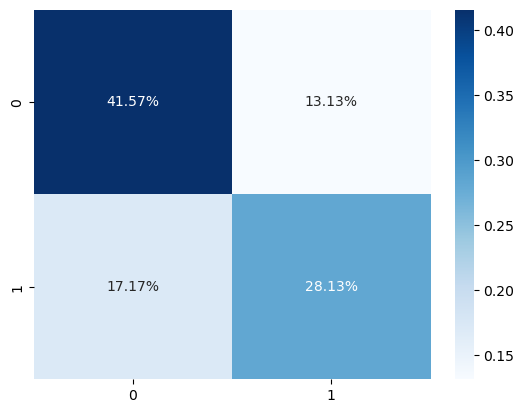

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7041555555555555
[[38089 11584]
 [15042 25285]]


<Axes: >

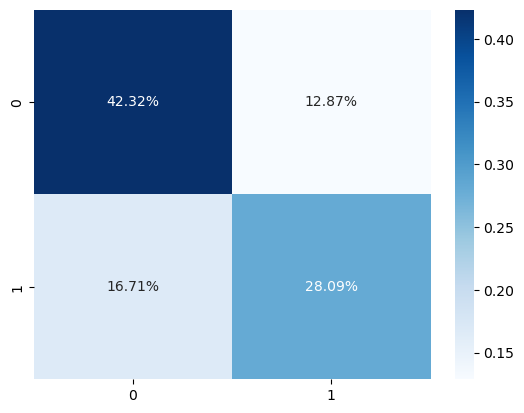

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [74]:
w = clf.coef_[0]
w = w/np.linalg.norm(w)

#np.save('w_512_sq_senet.npy',w)
#0.73

#np.save('w_512_sq_resnet.npy',w)
#0.68

#np.save('w_512_sq_vgg.npy',w)
#0.70

#np.save('w_512_ov_resnet.npy',w)
#0.70

#np.save('w_512_ov_senet.npy',w)
#0.69

#np.save('w_512_ov_vgg.npy',w)
#0.69

Non-oval Face - Assessor 1 - 18 * 512 (mean)

In [75]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_1, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

c:\Users\jason\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


Accuracy: 0.7933
[[3973  995]
 [1072 3960]]


<Axes: >

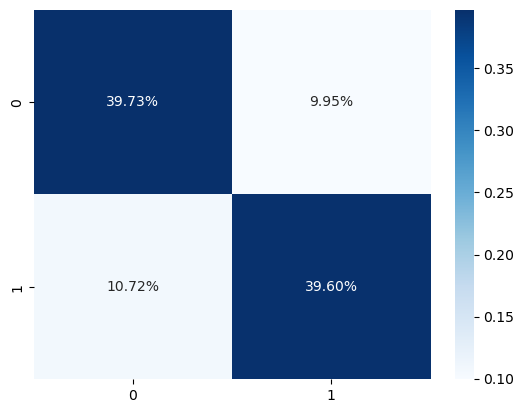

In [76]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7970444444444444
[[35711  9321]
 [ 8945 36023]]


<Axes: >

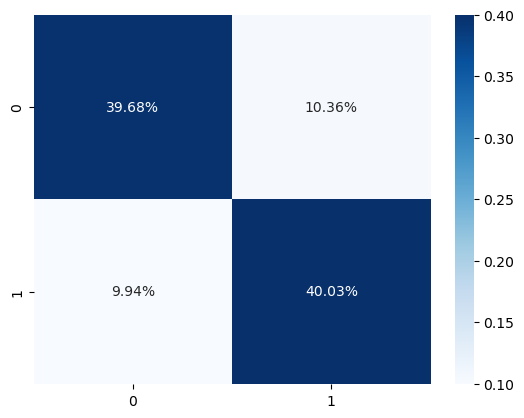

In [77]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [78]:
w = clf.coef_[0]
np.save('misc/w_aug_ass1_sq_mean.npy', w)

Non-oval Face - Assessor 2 - 18 * 512 (mean)

In [79]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_2, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

c:\Users\jason\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


Accuracy: 0.8289
[[4092  854]
 [ 857 4197]]


<Axes: >

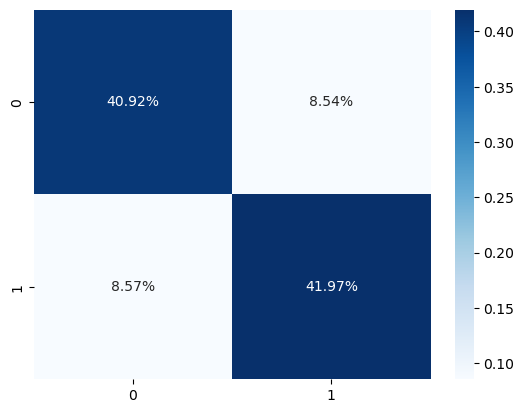

In [80]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8389333333333333
[[37982  7072]
 [ 7424 37522]]


<Axes: >

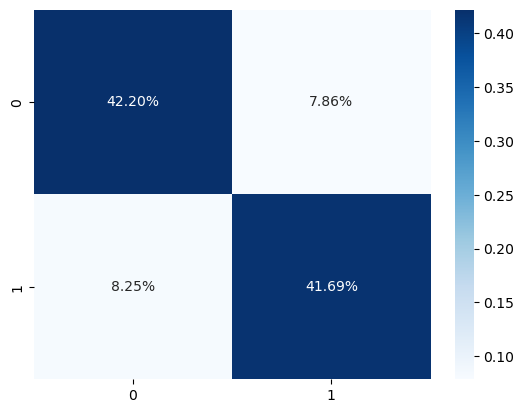

In [81]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [82]:
w = clf.coef_[0]
np.save('misc/w_aug_ass2_sq_mean.npy', w)

Non-oval Face - Assessor 3 - 18 * 512 (mean)

In [83]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_3, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

c:\Users\jason\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


Accuracy: 0.8039
[[4002  921]
 [1040 4037]]


<Axes: >

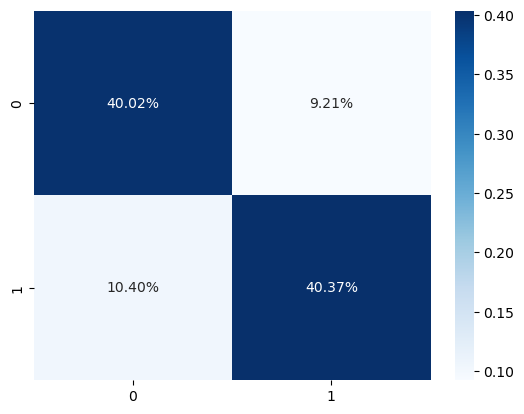

In [84]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8104666666666667
[[36872  8205]
 [ 8853 36070]]


<Axes: >

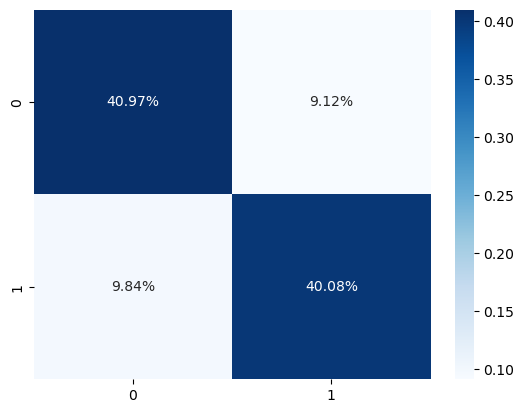

In [85]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [86]:
w = clf.coef_[0]
np.save('misc/w_aug_ass3_sq_mean.npy', w)

### IDK

In [87]:
#Loading age and smile hyperplane for conditionally modifying the memorability score

age = np.load("directions/age.npy")
smile = np.load("directions/smile.npy")

In [88]:
age = age.reshape(-1,1)
smile = smile.reshape(-1,1)
age.shape

(9216, 1)

In [89]:
age = age/np.linalg.norm(age)
smile = smile/np.linalg.norm(smile)

In [90]:
age = np.ravel(age)
smile = np.ravel(smile)
age.shape

(9216,)

In [91]:
print(type(age))
print(age.shape)
print(age)
# print(age.reshape(-1, 1).shape)
print(type(w_sq))
print(w_sq.shape)
print(w_sq)
# print(w_sq.reshape(-1, 1).shape)
# print(np.dot(w_sq.reshape(-1, 1).T, age)[0][0])

<class 'numpy.ndarray'>
(9216,)
[ 0.00149424 -0.00109641  0.00374811 ... -0.00075881  0.00020917
  0.00222063]
<class 'numpy.ndarray'>
(9216,)
[ 0.00949956 -0.02099452 -0.00291665 ... -0.00229227  0.01376369
  0.00849775]


In [92]:
# cond_age = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,age)[0][0])*age)
cond_age = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,age.reshape(-1,1))[0][0])*age)
print(cond_age.shape)
# cond_smile = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,smile)[0][0])*smile)
cond_smile = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,smile.reshape(-1,1))[0][0])*smile)
print(cond_smile.shape)

(9216,)
(9216,)


1/1 [==============================] - 1s 649ms/step
[0.2868322]


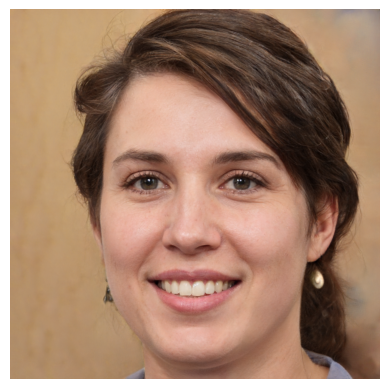

In [93]:
index = 0

x = X_train[index].copy()
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
# img = load_image(img)
plt.imshow(img)
plt.axis('off')

plt.savefig(f'face_images/faceimage_{index+1}.jpg', bbox_inches='tight', pad_inches=0)

1/1 [==============================] - 0s 142ms/step
[0.33223286]
1/1 [==============================] - 0s 111ms/step
[0.32571122]
1/1 [==============================] - 0s 108ms/step
[0.2464101]
1/1 [==============================] - 0s 98ms/step
[0.4694559]
1/1 [==============================] - 0s 86ms/step
[0.5304087]
1/1 [==============================] - 0s 86ms/step
[0.4530765]
1/1 [==============================] - 0s 91ms/step
[0.5231643]
1/1 [==============================] - 0s 92ms/step
[0.37738836]
1/1 [==============================] - 0s 85ms/step
[0.45250425]
1/1 [==============================] - 0s 87ms/step
[0.2515543]
1/1 [==============================] - 0s 88ms/step
[0.16133837]
1/1 [==============================] - 0s 104ms/step
[0.32593173]
1/1 [==============================] - 0s 87ms/step
[0.33013546]
1/1 [==============================] - 0s 91ms/step
[0.53892004]
1/1 [==============================] - 0s 90ms/step
[0.5784379]
1/1 [=======================

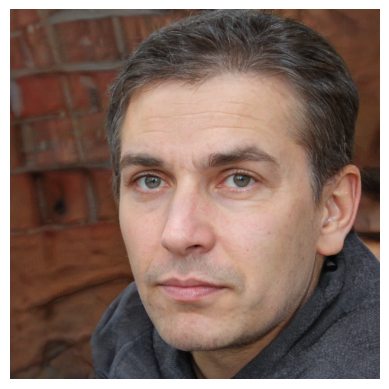

In [94]:
index = 0

for i in range(50):
    x = X_train[i].copy()
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    # img = load_image(img)
    plt.imshow(img)
    plt.axis('off')

    plt.savefig(f'face_images/faceimage_{i+1}.jpg', bbox_inches='tight', pad_inches=0)

1/1 [==============================] - 0s 88ms/step
[0.73709774]


(-0.5, 1023.5, 1023.5, -0.5)

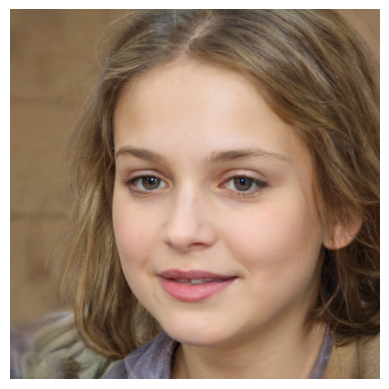

In [95]:
x = X_train[341].copy() + 3 * cond_age
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

### Modifying memorability score (Square-shaped)

1/1 [==============================] - 0s 90ms/step
[0.39597243]


(-0.5, 1023.5, 1023.5, -0.5)

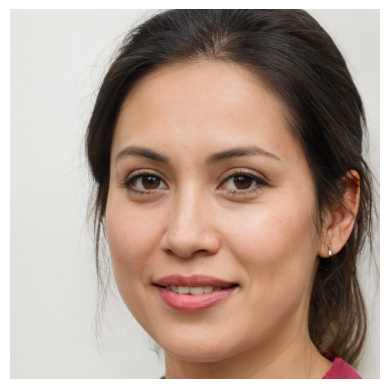

In [96]:
x = np.ravel(X_test[161])
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

1/1 [==============================] - 0s 86ms/step
[0.52506584]


(-0.5, 1023.5, 1023.5, -0.5)

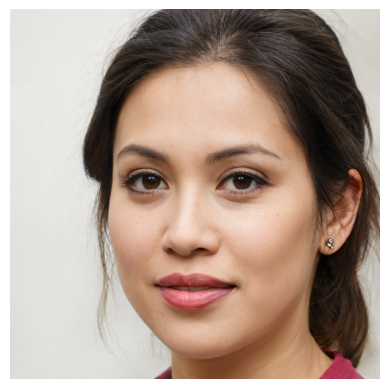

In [97]:
x = np.ravel(X_test[161]) +5* w_sq
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

### Using w from SVM

In [98]:
w_svm = np.load('misc/w2_oval_svm.npy')
w_svm = w_svm/np.linalg.norm(w_svm)

1/1 [==============================] - 0s 120ms/step
[0.39430568]


C:\Users\jason\AppData\Local\Temp\ipykernel_24852\409074531.py:29: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)


(-0.5, 198.5, 255.5, -0.5)

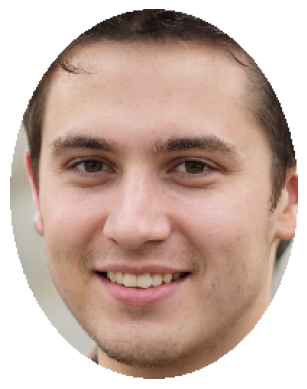

In [99]:
x = X_test[65].copy() 
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(calc_mem_ov(x))
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')

1/1 [==============================] - 0s 102ms/step
[0.5054323]


C:\Users\jason\AppData\Local\Temp\ipykernel_24852\409074531.py:29: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)


(-0.5, 199.5, 255.5, -0.5)

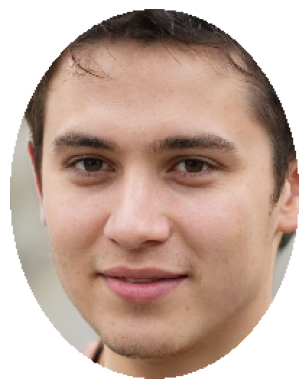

In [100]:
x = np.ravel(X_test[65]) + 3* np.ravel(w_svm)
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem_ov(x))
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')

### Modifying real faces memorability

In [101]:
# lat1 = np.load('sq_orig9590.jpg')
# lat1 = Image.open('sq_orig9590.jpg')
# lat1 = lat1.convert('L')
# lat1 = lat1.resize((512, 18))
lat1 = np.load('image_latent_again.npy')

print(lat1.shape)


(18, 512)


1/1 [==============================] - 0s 102ms/step
[0.29786295]


(-0.5, 1023.5, 1023.5, -0.5)

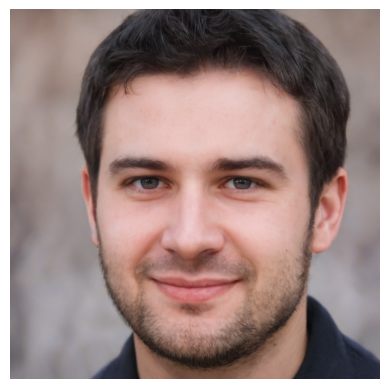

In [102]:
x = np.ravel(lat1) 
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

## latent directions

In [103]:
age_3 = np.load('directions/age_3.npy')
eyes_open = np.load('directions/eyes_open.npy')
face_shape = np.load('directions/face_shape.npy')
glasses = np.load('directions/glasses.npy')
gender = np.load('directions/gender.npy')
eye_distance = np.load('directions/eye_distance.npy')
beard = np.load('directions/beard.npy')
race_white = np.load('directions/race_white.npy')
race_black = np.load('directions/race_black.npy')
race_asian = np.load('directions/race_asian.npy')
emotion_angry = np.load('directions/emotion_angry.npy')
emotion_disgust = np.load('directions/emotion_disgust.npy')
emotion_fear = np.load('directions/emotion_fear.npy')
emotion_happy = np.load('directions/emotion_happy.npy')
emotion_sad = np.load('directions/emotion_sad.npy')
emotion_surprise = np.load('directions/emotion_surprise.npy')
width = np.load('directions/width.npy')
height = np.load('directions/height.npy')

age_3 = age_3.reshape(-1, 1)
eyes_open = eyes_open.reshape(-1, 1)
face_shape = face_shape.reshape(-1, 1)
glasses = glasses.reshape(-1, 1)
gender = gender.reshape(-1, 1)
eye_distance = eye_distance.reshape(-1, 1)
beard = beard.reshape(-1, 1)
race_white = race_white.reshape(-1, 1)
race_black = race_black.reshape(-1, 1)
race_asian = race_asian.reshape(-1, 1)
emotion_angry = emotion_angry.reshape(-1, 1)
emotion_disgust = emotion_disgust.reshape(-1, 1)
emotion_fear = emotion_fear.reshape(-1, 1)
emotion_happy = emotion_happy.reshape(-1, 1)
emotion_sad = emotion_sad.reshape(-1, 1)
emotion_surprise = emotion_surprise.reshape(-1, 1)
width = width.reshape(-1, 1)
height = height.reshape(-1, 1)


age_3 = age_3/np.linalg.norm(age_3)
eyes_open = eyes_open/np.linalg.norm(eyes_open)
face_shape = face_shape/np.linalg.norm(face_shape)
glasses = glasses/np.linalg.norm(glasses)
gender = gender/np.linalg.norm(gender)
eye_distance = eye_distance/np.linalg.norm(eye_distance)
beard = beard/np.linalg.norm(beard)
race_white = race_white/np.linalg.norm(race_white)
race_black = race_black/np.linalg.norm(race_black)
race_asian = race_asian/np.linalg.norm(race_asian)
emotion_angry = emotion_angry/np.linalg.norm(emotion_angry)
emotion_disgust = emotion_disgust/np.linalg.norm(emotion_disgust)
emotion_fear = emotion_fear/np.linalg.norm(emotion_fear)
emotion_happy = emotion_happy/np.linalg.norm(emotion_happy)
emotion_sad = emotion_sad/np.linalg.norm(emotion_sad)
emotion_surprise = emotion_surprise/np.linalg.norm(emotion_surprise)
width = width/np.linalg.norm(width)
height = height/np.linalg.norm(height)


age_3 = np.ravel(age_3)
eyes_open = np.ravel(eyes_open)
face_shape = np.ravel(face_shape)
glasses = np.ravel(glasses)
gender = np.ravel(gender)
eye_distance = np.ravel(eye_distance)
beard = np.ravel(beard)
race_white = np.ravel(race_white)
race_black = np.ravel(race_black)
race_asian = np.ravel(race_asian)
emotion_angry = np.ravel(emotion_angry)
emotion_disgust = np.ravel(emotion_disgust)
emotion_fear = np.ravel(emotion_fear)
emotion_happy = np.ravel(emotion_happy)
emotion_sad = np.ravel(emotion_sad)
emotion_surprise = np.ravel(emotion_surprise)
width = np.ravel(width)
height = np.ravel(height)

# cond_age3 = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,age.reshape(-1,1))[0][0])*age)
cond_age3 = w_sq - (np.dot(w_sq, age_3) * age_3)
# n1 - (n1.t * n2) * n2

# eyes_cond_gender = eyes_open - (np.dot(eyes_open, gender) * gender)
# cond_age = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,age)[0][0])*age)
eyes_cond_gender = eyes_open - np.ravel((np.dot(eyes_open.reshape(-1, 1).T, gender.reshape(-1,1))[0][0]) *gender)
# eyes_cond_beard = eyes_open - (np.dot(eyes_open, beard) * beard)
# eyes_cond_beard = eyes_open - np.ravel((np.dot(eyes_open.reshape(-1, 1).T, beard.reshape(-1,1))[0][0]) *beard)
eyes_cond_beard = eyes_open - np.ravel((np.dot(eyes_open.reshape(-1, 1).T, beard.reshape(-1,1))[0][0]) * beard)
shape_cond_beard = face_shape - np.ravel((np.dot(face_shape.reshape(-1, 1).T, beard.reshape(-1,1))[0][0]) * beard)

testing

In [104]:
#Loading age and smile hyperplane for conditionally modifying the memorability score

age = np.load("directions/age_2.npy")
smile = np.load("directions/smile_2.npy")

age = age.reshape(-1,1)
smile = smile.reshape(-1,1)
age.shape

age = age/np.linalg.norm(age)
smile = smile/np.linalg.norm(smile)

age = np.ravel(age)
smile = np.ravel(smile)
age.shape
print(w_sq)
print(age)

cond_age = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,age.reshape(-1,1))[0][0])*age)
cond_age = w_sq - (np.dot(w_sq, age) * age)

# n1 - (n1.t * n2) * n2
cond_smile = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,smile.reshape(-1,1))[0][0])*smile)


[ 0.00949956 -0.02099452 -0.00291665 ... -0.00229227  0.01376369
  0.00849775]
[ 0.00149424 -0.00109641  0.00374811 ... -0.00075881  0.00020917
  0.00222063]
(9216,)
(9216,)


1/1 [==============================] - 0s 91ms/step
[0.3506884]


(-0.5, 1023.5, 1023.5, -0.5)

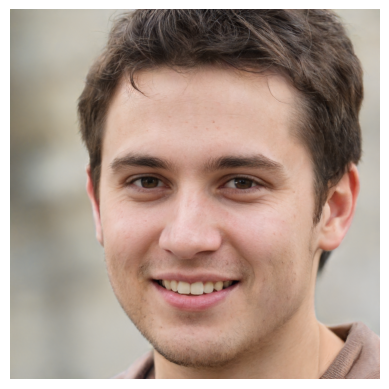

In [105]:
x = np.ravel(X_test[65])
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

In [106]:
print(X_test[65].copy())
x_example = X_test[65].copy() + 10 * w_sq
print(x_example)
print(w_sq)
print((x_example - X_test[65].copy())/w_sq)
print((x_example - X_test[65].copy())/smile)

print("\n")

x_example = X_test[65].copy() + 11 * smile
print(x_example)
print(smile)
print((x_example - X_test[65].copy())/smile)

[ 0.0604817   0.0722869   0.02463065 ... -0.1883833  -0.15823898
  0.07489955]
[ 0.15547732 -0.13765833 -0.00453589 ... -0.21130597 -0.02060211
  0.15987702]
[ 0.00949956 -0.02099452 -0.00291665 ... -0.00229227  0.01376369
  0.00849775]
[10. 10. 10. ... 10. 10. 10.]
[ 10.27456385  22.21436893   3.17750848 ...   1.77723808 -28.93065752
 -30.16883187]


[ 0.1621845  -0.03167273 -0.07633901 ... -0.33026042 -0.2105712
  0.04391552]
[ 0.00924571 -0.00945088 -0.00917906 ... -0.01289792 -0.00475747
 -0.00281673]
[11. 11. 11. ... 11. 11. 11.]


1/1 [==============================] - 0s 89ms/step
[0.261756]


(-0.5, 1023.5, 1023.5, -0.5)

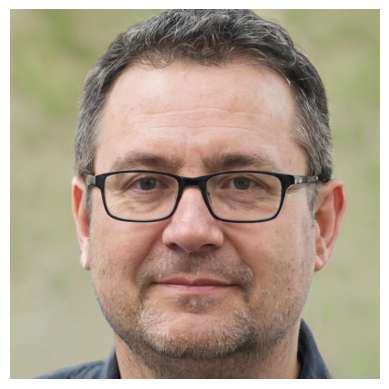

In [107]:
# x = np.ravel(X_test[65]) +3* w_sq 
# x = np.ravel(X_test[65]) + 15 * cond_age
# print(cond_smile)
# print(cond_age)
x = X_test[90].copy() - 1.5 * w_sq
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

Original: -0.3389521989919293
Modified: -0.48566447843930227
Difference Factor: -0.14671227944737297
1/1 [==============================] - 0s 103ms/step
[0.94130003]


(-0.5, 1023.5, 1023.5, -0.5)

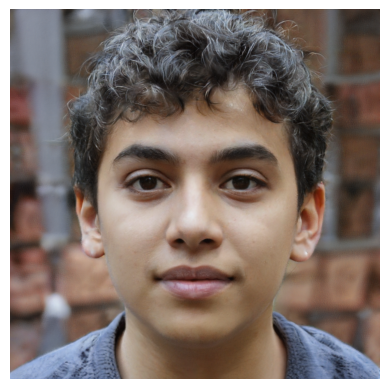

In [108]:
print(f"Original: {np.dot(X_test[61].copy(), eyes_open)}")
x = X_test[68].copy() + 10 * w_sq
print(f"Modified: {np.dot(x, eyes_open)}")
print(f"Difference Factor: {np.dot(x, eyes_open) - np.dot(X_test[61].copy(), eyes_open)}")
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
m = assessor_2.predict(sample)[0]
print(calc_mem(m))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

In [109]:
traits = [age, smile, width]
trait_names = ["age", "smile", "width"]
trait_levels = [0, 3, 6, 9, -3, -6, -9]
mem_differences = []
final_averages = []
final_std = []
output_str = []
trait = w_sq
# Age

zero_mem_list = []
three_mem_list = []
six_mem_list = []
nine_mem_list = []
neg_three_mem_list = []
neg_six_mem_list = []
neg_nine_mem_list = []

zero_factor_list = []
three_factor_list = []
six_factor_list = []
nine_factor_list = []
neg_three_factor_list = []
neg_six_factor_list = []
neg_nine_factor_list = []

for i in range(50):
    # 0
    x = X_test[i+50].copy() + 0 * trait
    diff_factor = np.dot(x, smile) - np.dot(X_test[i+50].copy(), smile)
    zero_factor_list.append(diff_factor)
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    zero_mem_list.append(calc_mem(x))

    # 5
    x = X_test[i+50].copy() + 5 * trait
    diff_factor = np.dot(x, smile) - np.dot(X_test[i+50].copy(), smile)
    three_factor_list.append(diff_factor)
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    three_mem_list.append(calc_mem(x))

    # 10
    x = X_test[i+50].copy() + 10 * trait
    diff_factor = np.dot(x, smile) - np.dot(X_test[i+50].copy(), smile)
    six_factor_list.append(diff_factor)
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    six_mem_list.append(calc_mem(x))

    # 15
    x = X_test[i+50].copy() + 15 * trait
    diff_factor = np.dot(x, smile) - np.dot(X_test[i+50].copy(), smile)
    nine_factor_list.append(diff_factor)
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    nine_mem_list.append(calc_mem(x))

    # -3
    x = X_test[i+50].copy() + -5 * trait
    diff_factor = np.dot(x, smile) - np.dot(X_test[i+50].copy(), smile)
    neg_three_factor_list.append(diff_factor)
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    neg_three_mem_list.append(calc_mem(x))

    # -6
    x = X_test[i+50].copy() + -10 * trait
    diff_factor = np.dot(x, smile) - np.dot(X_test[i+50].copy(), smile)
    neg_six_factor_list.append(diff_factor)
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    neg_six_mem_list.append(calc_mem(x))

    # -9
    x = X_test[i+50].copy() + -15 * trait
    diff_factor = np.dot(x, smile) - np.dot(X_test[i+50].copy(), smile)
    neg_nine_factor_list.append(diff_factor)
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    neg_nine_mem_list.append(calc_mem(x))

zero_factor_list_mean = np.mean(zero_factor_list)
three_factor_list_mean = np.mean(three_factor_list)
six_factor_list_mean = np.mean(six_factor_list)
nine_factor_list_mean = np.mean(nine_factor_list)
neg_three_factor_list_mean = np.mean(neg_three_factor_list)
neg_six_factor_list_mean = np.mean(neg_six_factor_list)
neg_nine_factor_list_mean = np.mean(neg_nine_factor_list)

zero_factor_list_std = np.std(zero_factor_list)
three_factor_list_std = np.std(three_factor_list)
six_factor_list_std = np.std(six_factor_list)
nine_factor_list_std = np.std(nine_factor_list)
neg_three_factor_list_std = np.std(neg_three_factor_list)
neg_six_factor_list_std = np.std(neg_six_factor_list)
neg_nine_factor_list_std = np.std(neg_nine_factor_list)

print(f"0: {zero_factor_list_mean} +-  {zero_factor_list_std}")
print(f"5: {three_factor_list_mean} +-  {three_factor_list_std}")
print(f"10: {six_factor_list_mean} +-  {six_factor_list_std}")
print(f"15: {nine_factor_list_mean} +-  {nine_factor_list_std}")
print(f"-5: {neg_three_factor_list_mean} +-  {neg_three_factor_list_std}")
print(f"-10: {neg_six_factor_list_mean} +-  {neg_six_factor_list_std}")
print(f"-15: {neg_nine_factor_list_mean} +-  {neg_nine_factor_list_std}")


1/1 [==============================] - 0s 99ms/step
[0.33641982]
1/1 [==============================] - 0s 98ms/step
[0.42333886]
1/1 [==============================] - 0s 89ms/step
[0.5897594]
1/1 [==============================] - 0s 86ms/step
[0.68135154]
1/1 [==============================] - 0s 83ms/step
[0.27506834]
1/1 [==============================] - 0s 89ms/step
[0.2185589]
1/1 [==============================] - 0s 94ms/step
[0.17809333]
1/1 [==============================] - 0s 87ms/step
[0.22683866]
1/1 [==============================] - 0s 86ms/step
[0.2881592]
1/1 [==============================] - 0s 90ms/step
[0.4156954]
1/1 [==============================] - 0s 87ms/step
[0.5700207]
1/1 [==============================] - 0s 98ms/step
[0.18688111]
1/1 [==============================] - 0s 98ms/step
[0.15320195]
1/1 [==============================] - 0s 91ms/step
[0.16828535]
1/1 [==============================] - 0s 84ms/step
[0.4428615]
1/1 [==========================

In [110]:
# traits = [age, smile, eyes_open, gender, width]
# trait_names = ["age", "smile", "eyes_open", "gender", "width"]
"""
traits = [age, smile, width]
trait_names = ["age", "smile", "width"]
trait_levels = [0, 3, 6, 9, -3, -6, -9]
mem_differences = []
final_averages = []
final_std = []
output_str = []
trait = gender
# Age

zero_mem_list = []
three_mem_list = []
six_mem_list = []
nine_mem_list = []
neg_three_mem_list = []
neg_six_mem_list = []
neg_nine_mem_list = []

zero_mem_difference_list = []
three_mem_difference_list = []
six_mem_difference_list = []
nine_mem_difference_list = []
neg_three_mem_difference_list = []
neg_six_mem_difference_list = []
neg_nine_mem_difference_list = []

for i in range(50):
    # 0
    x = X_test[i+50].copy() + 0 * trait
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    zero_mem_list.append(calc_mem(x))

    # 3
    x = X_test[i+50].copy() + 3 * trait
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    three_mem_list.append(calc_mem(x))

    # 6
    x = X_test[i+50].copy() + 6 * trait
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    six_mem_list.append(calc_mem(x))

    # 9
    x = X_test[i+50].copy() + 9 * trait
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    nine_mem_list.append(calc_mem(x))

    # -3
    x = X_test[i+50].copy() + -3 * trait
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    neg_three_mem_list.append(calc_mem(x))

    # -6
    x = X_test[i+50].copy() + -6 * trait
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    neg_six_mem_list.append(calc_mem(x))

    # -9
    x = X_test[i+50].copy() + -9 * trait
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))
    neg_nine_mem_list.append(calc_mem(x))

for i in range(len(zero_mem_list)):
    zero_mem_difference_list.append(zero_mem_list[i] - zero_mem_list[i])
    three_mem_difference_list.append(three_mem_list[i] - zero_mem_list[i])
    six_mem_difference_list.append(six_mem_list[i] - zero_mem_list[i])
    nine_mem_difference_list.append(nine_mem_list[i] - zero_mem_list[i])
    neg_three_mem_difference_list.append(neg_three_mem_list[i] - zero_mem_list[i])
    neg_six_mem_difference_list.append(neg_six_mem_list[i] - zero_mem_list[i])
    neg_nine_mem_difference_list.append(neg_nine_mem_list[i] - zero_mem_list[i])

zero_mem_list_mean = np.mean(zero_mem_list)
three_mem_list_mean = np.mean(three_mem_list)
six_mem_list_mean = np.mean(six_mem_list)
nine_mem_list_mean = np.mean(nine_mem_list)
neg_three_mem_list_mean = np.mean(neg_three_mem_list)
neg_six_mem_list_mean = np.mean(neg_six_mem_list)
neg_nine_mem_list_mean = np.mean(neg_nine_mem_list)

zero_mem_list_std = np.std(zero_mem_list)
three_mem_list_std = np.std(three_mem_list)
six_mem_list_std = np.std(six_mem_list)
nine_mem_list_std = np.std(nine_mem_list)
neg_three_mem_list_std = np.std(neg_three_mem_list)
neg_six_mem_list_std = np.std(neg_six_mem_list)
neg_nine_mem_list_std = np.std(neg_nine_mem_list)

zero_mem_difference_list_mean = np.mean(zero_mem_difference_list)
three_mem_difference_list_mean = np.mean(three_mem_difference_list)
six_mem_difference_list_mean = np.mean(six_mem_difference_list)
nine_mem_difference_list_mean = np.mean(nine_mem_difference_list)
neg_three_mem_difference_list_mean = np.mean(neg_three_mem_difference_list)
neg_six_mem_difference_list_mean = np.mean(neg_six_mem_difference_list)
neg_nine_mem_difference_list_mean = np.mean(neg_nine_mem_difference_list)

zero_mem_difference_list_std = np.std(zero_mem_difference_list)
three_mem_difference_list_std = np.std(three_mem_difference_list)
six_mem_difference_list_std = np.std(six_mem_difference_list)
nine_mem_difference_list_std = np.std(nine_mem_difference_list)
neg_three_mem_difference_list_std = np.std(neg_three_mem_difference_list)
neg_six_mem_difference_list_std = np.std(neg_six_mem_difference_list)
neg_nine_mem_difference_list_std = np.std(neg_nine_mem_difference_list)


print(f"Trait gender:\nOriginal - mem_score={zero_mem_list_mean}+-{zero_mem_list_std} ({zero_mem_difference_list_mean}+-{zero_mem_difference_list_std})")
print(f"+3 - mem_score={three_mem_list_mean}+-{zero_mem_list_std} ({three_mem_difference_list_mean}+-{three_mem_difference_list_std})")
print(f"+6 - mem_score={six_mem_list_mean}+-{zero_mem_list_std} ({six_mem_difference_list_mean}+-{six_mem_difference_list_std})")
print(f"+9 - mem_score={nine_mem_list_mean}+-{zero_mem_list_std} ({nine_mem_difference_list_mean}+-{nine_mem_difference_list_std})")
print(f"-3 - mem_score={neg_three_mem_list_mean}+-{zero_mem_list_std} ({neg_three_mem_difference_list_mean}+-{neg_three_mem_difference_list_std})")
print(f"-6 - mem_score={neg_six_mem_list_mean}+-{zero_mem_list_std} ({neg_six_mem_difference_list_mean}+-{neg_six_mem_difference_list_std})")
print(f"-9 - mem_score={neg_nine_mem_list_mean}+-{zero_mem_list_std} ({neg_nine_mem_difference_list_mean}+-{neg_nine_mem_difference_list_std})")

"""


'\ntraits = [age, smile, width]\ntrait_names = ["age", "smile", "width"]\ntrait_levels = [0, 3, 6, 9, -3, -6, -9]\nmem_differences = []\nfinal_averages = []\nfinal_std = []\noutput_str = []\ntrait = gender\n# Age\n\nzero_mem_list = []\nthree_mem_list = []\nsix_mem_list = []\nnine_mem_list = []\nneg_three_mem_list = []\nneg_six_mem_list = []\nneg_nine_mem_list = []\n\nzero_mem_difference_list = []\nthree_mem_difference_list = []\nsix_mem_difference_list = []\nnine_mem_difference_list = []\nneg_three_mem_difference_list = []\nneg_six_mem_difference_list = []\nneg_nine_mem_difference_list = []\n\nfor i in range(50):\n    # 0\n    x = X_test[i+50].copy() + 0 * trait\n    x = x.reshape((1,18,512))\n    out = generator.synthesis_network(x)\n    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)\n    img = img.numpy()[0]\n    sample = load_image(img)\n    sample = sample.reshape((1,224,224,3))\n    x = assessor_2.predict(sample)[0]\n    print(calc_mem(x))\n    zero_mem_lis

In [111]:
"""
print(final_averages)
print(final_std)

print(len(final_averages))
print(final_averages[0])
print(final_std[0])
print("\n")

print(f"Trait 1 (Age):\nOriginal - mem_score={final_averages[0][0]}+-{final_std[0][0]} ({final_averages[0][1]}+-{final_std[0][1]})")
print(f"+3 - mem_score={final_averages[0][2]}+-{final_std[0][2]} ({final_averages[0][3]}+-{final_std[0][3]})")
print(f"+6 - mem_score={final_averages[0][4]}+-{final_std[0][4]} ({final_averages[0][5]}+-{final_std[0][5]})")
print(f"+9 - mem_score={final_averages[0][6]}+-{final_std[0][6]} ({final_averages[0][7]}+-{final_std[0][7]})")
"""

'\nprint(final_averages)\nprint(final_std)\n\nprint(len(final_averages))\nprint(final_averages[0])\nprint(final_std[0])\nprint("\n")\n\nprint(f"Trait 1 (Age):\nOriginal - mem_score={final_averages[0][0]}+-{final_std[0][0]} ({final_averages[0][1]}+-{final_std[0][1]})")\nprint(f"+3 - mem_score={final_averages[0][2]}+-{final_std[0][2]} ({final_averages[0][3]}+-{final_std[0][3]})")\nprint(f"+6 - mem_score={final_averages[0][4]}+-{final_std[0][4]} ({final_averages[0][5]}+-{final_std[0][5]})")\nprint(f"+9 - mem_score={final_averages[0][6]}+-{final_std[0][6]} ({final_averages[0][7]}+-{final_std[0][7]})")\n'

# Testing with real face

In [112]:
print(lat1.shape)
print(lat1[0].shape)
print(lat1[1][1])
print(lat1[2][1])

(18, 512)
(512,)
-0.16298057
-0.13935235


(18, 512)


1/1 [==============================] - 0s 103ms/step
[0.30797616]


(-0.5, 1023.5, 1023.5, -0.5)

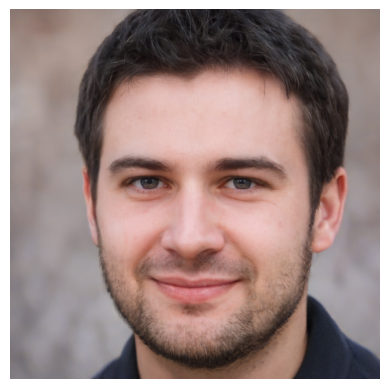

In [113]:
print(lat1.shape)
x = np.ravel(lat1) 
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

1/1 [==============================] - 0s 90ms/step
[0.77309704]


(-0.5, 1023.5, 1023.5, -0.5)

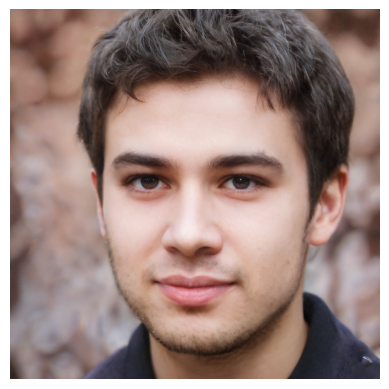

In [114]:
x = np.ravel(lat1).copy() + 15 * w_sq
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

In [115]:
print(age.shape)
print(age[512])
print(age[1024])
age_reshaped = age.copy().reshape(18,512)
print(age_reshaped[0][5])
print(age_reshaped[1][5])
print(age_reshaped[2][5])
print(age_reshaped[3][5])

(9216,)
0.0014942368169866176
0.0014942368169866176
-0.015511037365148026
-0.015511037365148026
-0.015511037365148026
-0.015511037365148026


1/1 [==============================] - 0s 89ms/step
[0.564445]


(-0.5, 1023.5, 1023.5, -0.5)

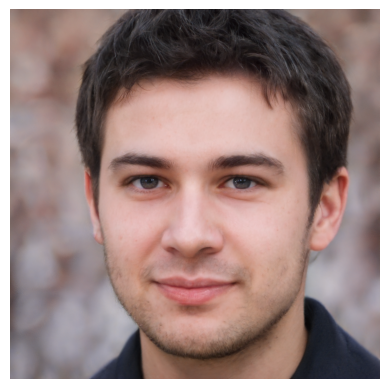

In [116]:
single_w_sq = w_sq.copy().reshape((18,512))
# single_w_sq[np.arange(18) != 0, :] = 0
# single_w_sq[np.arange(18) != 5, :] = 0
# single_w_sq[np.logical_and(np.arange(18) <= 6, np.arange(18)>2), :] = 0
single_w_sq[np.logical_or(np.arange(18) > 6, np.arange(18)<=2), :] = 0
# single_w_sq[:, np.arange(512) != 81] = 0
# print(single_w_sq[0][88])
single_w_sq = single_w_sq.reshape((9216))
# print(single_w_sq)
# print(len(single_w_sq))
x = np.ravel(lat1).copy() + 12 * single_w_sq
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

In [117]:
def calculate_angle(vector1, vector2):
    dot_product = np.sum(vector1 * vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    cosine_similarity = dot_product / (norm1 * norm2)
    angle = np.arccos(cosine_similarity)
    return np.degrees(angle)

In [118]:
# single image

direction_vector = w_sq.copy().reshape((18,512))
face_vector = np.ravel(lat1).copy().reshape((18,512))

# calculate angles between corresponding subvectors
angles = []
for i in range(18):
    subvector1 = direction_vector[i]
    subvector2 = face_vector[i]
    angle = calculate_angle(subvector1, subvector2)
    angles.append(angle)

# Print the angles
for i, angle in enumerate(angles):
    print(f"Angle between subvector {i+1}: {angle} degrees")

Average angle between subvector 1: 87.53217545968373 degrees
Average angle between subvector 2: 85.32209889043149 degrees
Average angle between subvector 3: 88.36510617145183 degrees
Average angle between subvector 4: 86.73575551042708 degrees
Average angle between subvector 5: 87.68844570755165 degrees
Average angle between subvector 6: 89.17760312115243 degrees
Average angle between subvector 7: 86.28816952577071 degrees
Average angle between subvector 8: 89.57737294148657 degrees
Average angle between subvector 9: 87.74684074650581 degrees
Average angle between subvector 10: 90.22678252325575 degrees
Average angle between subvector 11: 87.87335665554428 degrees
Average angle between subvector 12: 89.51334147372033 degrees
Average angle between subvector 13: 88.71066594869899 degrees
Average angle between subvector 14: 89.841376988825 degrees
Average angle between subvector 15: 89.57737022116986 degrees
Average angle between subvector 16: 89.24139758240949 degrees
Average angle betwe

1/1 [==============================] - 0s 89ms/step
[0.3033607]


(-0.5, 1023.5, 1023.5, -0.5)

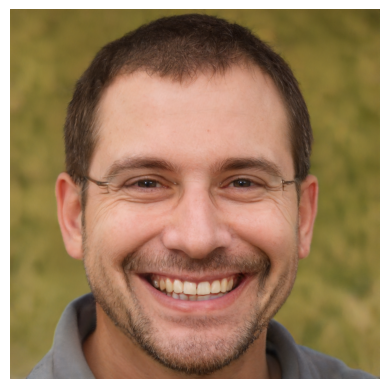

In [119]:
# single image
lat_val = np.load(f"face_inversions/latent_image9.npy")

x = np.ravel(lat_val).copy() + 15 * smile
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

In [120]:
# single image
lat_val = np.load(f"face_inversions/latent_image9.npy")
bargraph_data = []

print("Original:\n")

direction_vector = eyes_open.copy().reshape((18,512))
# face_vector = X_test[0].copy().reshape((18,512))
face_vector = np.ravel(lat_val).copy() + 0*eyes_open
face_vector = face_vector.reshape((18,512))
# face_vector = X_test[90].copy().reshape((18,512))

# calculate angles between corresponding subvectors
original_angles = []
for i in range(18):
    subvector1 = direction_vector[i]
    subvector2 = face_vector[i]
    angle = calculate_angle(subvector1, subvector2)
    original_angles.append(angle)

# Print the angles
for i, angle in enumerate(original_angles):
    print(f"Original angle between subvector {i+1}: {angle} degrees")


print("\n+15 Direction\n")

face_vector = np.ravel(lat_val).copy() + 15*eyes_open
face_vector = face_vector.reshape((18,512))

# calculate angles between corresponding subvectors
plus_angles = []
for i in range(18):
    subvector1 = direction_vector[i]
    subvector2 = face_vector[i]
    angle = calculate_angle(subvector1, subvector2)
    plus_angles.append(angle)

# Print the angles
for i, angle in enumerate(plus_angles):
    print(f"Plus angle between subvector {i+1}: {angle} degrees. Difference: {angle - original_angles[i]} degrees. Percentage: {100*(angle - original_angles[i])/original_angles[i]}%")
    bargraph_data.append(abs(angle - original_angles[i]))

print("\n-15 Direction\n")

face_vector = np.ravel(lat_val).copy() - 15*eyes_open
face_vector = face_vector.reshape((18,512))

# calculate angles between corresponding subvectors
minus_angles = []
for i in range(18):
    subvector1 = direction_vector[i]
    subvector2 = face_vector[i]
    angle = calculate_angle(subvector1, subvector2)
    minus_angles.append(angle)

# Print the angles
for i, angle in enumerate(plus_angles):
    print(f"Minus angle between subvector {i+1}: {angle} degrees. Difference: {angle - original_angles[i]} degrees. Percentage: {100*(angle - original_angles[i])/original_angles[i]}%")

Original:

Original angle between subvector 1: 91.3775079961478 degrees
Original angle between subvector 2: 92.32579414082461 degrees
Original angle between subvector 3: 90.56206360826953 degrees
Original angle between subvector 4: 92.36946233750267 degrees
Original angle between subvector 5: 91.06016160819361 degrees
Original angle between subvector 6: 93.1404534013352 degrees
Original angle between subvector 7: 89.96056680533496 degrees
Original angle between subvector 8: 91.35207222203239 degrees
Original angle between subvector 9: 89.96974112107095 degrees
Original angle between subvector 10: 88.48901770871979 degrees
Original angle between subvector 11: 91.75098125566254 degrees
Original angle between subvector 12: 92.3469945338954 degrees
Original angle between subvector 13: 90.327539639237 degrees
Original angle between subvector 14: 90.45531182041138 degrees
Original angle between subvector 15: 90.89807229981393 degrees
Original angle between subvector 16: 92.06235771087383 deg

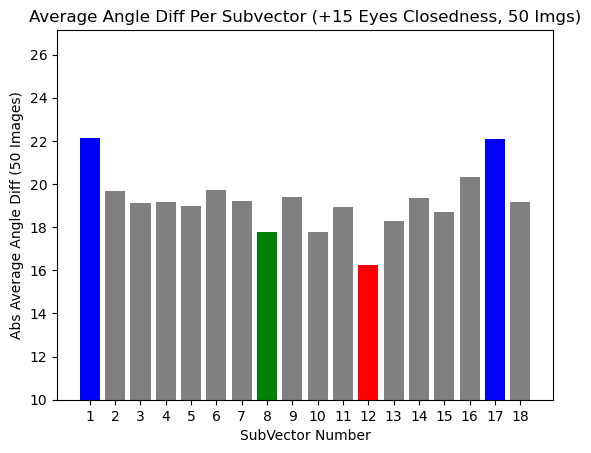

In [121]:
import matplotlib.pyplot as plt

# Your array of angle differences
# angle_differences = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]
angle_differences = bargraph_data

# Find the indices of the two greatest values and the index of the lowest value
sorted_indices = sorted(range(len(angle_differences)), key=lambda k: angle_differences[k])
min_index = sorted_indices[0]
max_indices = sorted_indices[-2:]

# Specify a specific x value to highlight
specific_x_value = 8
specific_x_value_2 = 8 

# Create a list of colors based on conditions
colors = ['blue' if i in max_indices else 'green' if (i == specific_x_value - 1 or i == specific_x_value_2 - 1) else 'red' if i == min_index else 'gray' for i in range(len(angle_differences))]

# Create the bar graph with custom colors
plt.bar(range(1, len(angle_differences) + 1), angle_differences, tick_label=range(1, len(angle_differences) + 1), color=colors)


# Add labels and title
plt.xlabel('SubVector Number')
plt.ylabel('Abs Average Angle Diff (50 Images)')
plt.title('Average Angle Diff Per Subvector (+15 Eyes Closedness, 50 Imgs)')

plt.ylim(10, max(angle_differences)+5)


# Show the graph
plt.show()

In [122]:
# Averages of batch images
all_original_angles = []
all_plus_angles = []
all_plus_angle_differences = []
all_plus_angle_percentages = []
all_minus_angles = []
all_minus_angle_differences = []
all_minus_angle_percentages = []
bargraph_data = []

for i in range(50):
    lat_val = np.load(f"face_inversions/latent_image{i+1}.npy")

    # print("Original:\n")

    direction_vector = eyes_open.copy().reshape((18,512))
    face_vector = np.ravel(lat_val).copy() + 0*eyes_open
    face_vector = face_vector.reshape((18,512))

    # calculate angles between corresponding subvectors
    original_angles = []
    for i in range(18):
        subvector1 = direction_vector[i]
        subvector2 = face_vector[i]
        angle = calculate_angle(subvector1, subvector2)
        original_angles.append(angle)
    
    all_original_angles.append(original_angles)


    # print("\n+15 Direction\n")

    face_vector = np.ravel(lat_val).copy() + 15*eyes_open
    face_vector = face_vector.reshape((18,512))

    # calculate angles between corresponding subvectors
    plus_angles = []
    plus_angle_differences = []
    plus_angle_percentages = []
    for i in range(18):
        subvector1 = direction_vector[i]
        subvector2 = face_vector[i]
        angle = calculate_angle(subvector1, subvector2)
        plus_angles.append(angle)
        plus_angle_differences.append(angle - original_angles[i])
        plus_angle_percentages.append(100*(angle - original_angles[i])/original_angles[i])

    all_plus_angles.append(plus_angles)
    all_plus_angle_differences.append(plus_angle_differences)
    all_plus_angle_percentages.append(plus_angle_percentages)


    # print("\n-15 Direction\n")

    face_vector = np.ravel(lat_val).copy() - 15*eyes_open
    face_vector = face_vector.reshape((18,512))

    # calculate angles between corresponding subvectors
    minus_angles = []
    minus_angle_differences = []
    minus_angle_percentages = []
    for i in range(18):
        subvector1 = direction_vector[i]
        subvector2 = face_vector[i]
        angle = calculate_angle(subvector1, subvector2)
        minus_angles.append(angle)
        minus_angle_differences.append(angle - original_angles[i])
        minus_angle_percentages.append(100*(angle - original_angles[i])/original_angles[i])

    all_minus_angles.append(minus_angles)
    all_minus_angle_differences.append(minus_angle_differences)
    all_minus_angle_percentages.append(minus_angle_percentages)

print("Original:\n")
for i in range(18):
    trait_angles = []
    for y in all_original_angles:
        trait_angles.append(y[i])
    print(f"Average subvector {i+1}: {np.mean(trait_angles)} degrees +- {np.std(trait_angles)} degrees")

print("\n+15 Direction\n")
for i in range(18):
    trait_angles = []
    trait_angle_differences = []
    trait_angle_percentages = []
    for y in all_plus_angles:
        trait_angles.append(y[i])
    #print(f"Average plus subvector {i+1}: {np.mean(trait_angles)} degrees +- {np.std(trait_angles)} degrees")
    for y in all_plus_angle_differences:
        trait_angle_differences.append(y[i])
    print(f"Average plus subvector difference {i+1}: {np.mean(trait_angle_differences)} degrees +- {np.std(trait_angle_differences)} degrees")
    # bargraph_data.append(abs(np.mean(trait_angle_differences)))
    for y in all_plus_angle_percentages:
        trait_angle_percentages.append(y[i])
    # print(f"Average plus subvector percentage {i+1}: {np.mean(trait_angle_percentages)} +- {np.std(trait_angle_percentages)}\n")

print("\n-15 Direction\n")
for i in range(18):
    trait_angles = []
    trait_angle_differences = []
    trait_angle_percentages = []
    for y in all_minus_angles:
        trait_angles.append(y[i])
    #print(f"Average minus subvector {i+1}: {np.mean(trait_angles)} degrees +- {np.std(trait_angles)} degrees")
    for y in all_minus_angle_differences:
        trait_angle_differences.append(y[i])
    print(f"Average minus subvector difference {i+1}: {np.mean(trait_angle_differences)} degrees +- {np.std(trait_angle_differences)} degrees")
    bargraph_data.append(abs(np.mean(trait_angle_differences)))
    for y in all_minus_angle_percentages:
        trait_angle_percentages.append(y[i])
    #print(f"Average minus subvector percentage {i+1}: {np.mean(trait_angle_percentages)} +- {np.std(trait_angle_percentages)}\n")


Original:

Average subvector 1: 91.49219964054559 degrees +- 0.7902746824727099 degrees
Average subvector 2: 91.16517994566169 degrees +- 1.284956736904534 degrees
Average subvector 3: 90.60391860177842 degrees +- 1.3261716164178914 degrees
Average subvector 4: 92.0240854797869 degrees +- 1.2645159137047848 degrees
Average subvector 5: 91.6713783725903 degrees +- 1.5132224262804381 degrees
Average subvector 6: 92.21895606659835 degrees +- 1.7521423034567585 degrees
Average subvector 7: 90.14254079704725 degrees +- 1.3045462837574844 degrees
Average subvector 8: 90.80751611191901 degrees +- 1.2081385519635062 degrees
Average subvector 9: 90.73832951482328 degrees +- 1.3888612495025008 degrees
Average subvector 10: 88.82122578320818 degrees +- 1.4108978054517642 degrees
Average subvector 11: 91.92077980490552 degrees +- 0.9329833492497842 degrees
Average subvector 12: 91.83334803464959 degrees +- 1.4758715053991358 degrees
Average subvector 13: 90.30619769591166 degrees +- 0.852670742414

In [123]:
all_angles = []
for i in range(50):
    lat_val = np.load(f"face_inversions/latent_image{i+1}.npy")

    # direction_vector = w_sq.copy().reshape((18,512))
    direction_vector = gender.copy().reshape((18,512))
    face_vector = np.ravel(lat_val).copy().reshape((18,512))

    # calculate angles between corresponding subvectors
    angles = []
    for i in range(18):
        subvector1 = direction_vector[i]
        subvector2 = face_vector[i]
        angle = calculate_angle(subvector1, subvector2)
        angles.append(angle)

    # append the angles
    all_angles.append(angles)

for i in range(18):
    trait_angles = []
    for y in all_angles:
        trait_angles.append(y[i])
    print(f"Average subvector {i+1}: {np.mean(trait_angles)} degrees +- {np.std(trait_angles)} degrees")


Average subvector 1: 88.95244208944106 degrees +- 4.375570146948664 degrees
Average subvector 2: 89.52933051489481 degrees +- 3.1332970506078595 degrees
Average subvector 3: 89.71328386264433 degrees +- 2.592506287950379 degrees
Average subvector 4: 89.9617409769668 degrees +- 2.9049204053908815 degrees
Average subvector 5: 89.66100256117541 degrees +- 2.543350089337792 degrees
Average subvector 6: 89.97777790555212 degrees +- 3.2088722342454297 degrees
Average subvector 7: 88.9503558425351 degrees +- 2.5950932648316374 degrees
Average subvector 8: 88.73679872488069 degrees +- 5.1560157115914 degrees
Average subvector 9: 89.59942284508362 degrees +- 3.809527565740939 degrees
Average subvector 10: 90.87129418253912 degrees +- 5.73083226846446 degrees
Average subvector 11: 88.93858296457341 degrees +- 5.2570285708824604 degrees
Average subvector 12: 86.87204012705384 degrees +- 5.461830450484902 degrees
Average subvector 13: 87.06533423346485 degrees +- 5.065365563074048 degrees
Average 

In [124]:
all_angles = []
for i in range(50):
    lat_val = np.load(f"face_inversions/latent_image{i+1}.npy")

    # direction_vector = w_sq.copy().reshape((18,512))
    direction_vector = gender.copy().reshape((18,512))
    face_vector = np.ravel(lat_val).copy() - 15*gender
    face_vector = face_vector.reshape((18,512))

    # calculate angles between corresponding subvectors
    angles = []
    for i in range(18):
        subvector1 = direction_vector[i]
        subvector2 = face_vector[i]
        angle = calculate_angle(subvector1, subvector2)
        angles.append(angle)

    # append the angles
    all_angles.append(angles)

for i in range(18):
    trait_angles = []
    for y in all_angles:
        trait_angles.append(y[i])
    print(f"Average subvector {i+1}: {np.mean(trait_angles)} degrees +- {np.std(trait_angles)} degrees")

Average subvector 1: 110.98998782796512 degrees +- 4.185157761801901 degrees
Average subvector 2: 108.31439429756394 degrees +- 3.423457076655864 degrees
Average subvector 3: 108.29658269716066 degrees +- 3.236679570525652 degrees
Average subvector 4: 108.701636232346 degrees +- 3.2953249326138025 degrees
Average subvector 5: 108.21905667466068 degrees +- 2.8445702104655903 degrees
Average subvector 6: 108.82902828276538 degrees +- 3.615558034574512 degrees
Average subvector 7: 108.41323083498453 degrees +- 2.905976139310247 degrees
Average subvector 8: 106.08625775093957 degrees +- 5.330462024506741 degrees
Average subvector 9: 108.33027191171654 degrees +- 3.8207040682040785 degrees
Average subvector 10: 108.55168425893342 degrees +- 5.269848717960593 degrees
Average subvector 11: 107.72750816295337 degrees +- 5.135949518184068 degrees
Average subvector 12: 103.39204920722473 degrees +- 5.336505444307865 degrees
Average subvector 13: 105.68540952624089 degrees +- 4.703606495186697 de

In [125]:
all_angles = []
for i in range(50):
    lat_val = np.load(f"face_inversions/latent_image{i+1}.npy")

    # direction_vector = w_sq.copy().reshape((18,512))
    direction_vector = eye_distance.copy().reshape((18,512))
    face_vector = np.ravel(lat_val).copy().reshape((18,512))

    # calculate angles between corresponding subvectors
    angles = []
    for i in range(18):
        subvector1 = direction_vector[i]
        subvector2 = face_vector[i]
        angle = calculate_angle(w_sq.copy().reshape((18, 512)), subvector2)
        angles.append(angle)

    # append the angles
    all_angles.append(angles)

print("Comparing image subvectors with complete direction vector:\n")
for i in range(18):
    trait_angles = []
    for y in all_angles:
        trait_angles.append(y[i])
    print(f"Subvector {i+1}: {np.mean(trait_angles)} +- {np.std(trait_angles)}")


Comparing image subvectors with complete direction vector:

Subvector 1: 76.01792764730925 +- 4.677717361078199
Subvector 2: 66.3267347533039 +- 8.906024405445995
Subvector 3: 74.46382055056179 +- 8.099852753814433
Subvector 4: 74.5710803508931 +- 8.044674009864877
Subvector 5: 79.62076793248418 +- 5.0732680407835975
Subvector 6: 86.21740578259279 +- 9.548899705008903
Subvector 7: 73.63088498525447 +- 7.000458524435067
Subvector 8: 80.2115228611958 +- 6.884740043515236
Subvector 9: 76.76000226039 +- 6.992936456083264
Subvector 10: 88.77290521603314 +- 8.77090710447262
Subvector 11: 82.51514410558086 +- 6.296325952879226
Subvector 12: 88.24954117171364 +- 8.969041451683385
Subvector 13: 82.27207623405717 +- 7.571902862860667
Subvector 14: 84.7772392423023 +- 5.454159076704064
Subvector 15: 83.30363451270651 +- 6.163370598722365
Subvector 16: 82.3843693637711 +- 5.8566854853916395
Subvector 17: 76.15620757013829 +- 4.69696778335263
Subvector 18: 81.4782772281203 +- 5.618066543925133


In [126]:
all_angles = []
for i in range(50):
    lat_val = np.load(f"face_inversions/latent_image{i+1}.npy")

    # direction_vector = w_sq.copy().reshape((18,512))
    direction_vector = gender.copy().reshape((18,512))
    face_vector = np.ravel(lat_val).copy().reshape((18,512))

    # calculate angles between corresponding subvectors
    angles = []
    for i in range(18):
        subvector1 = direction_vector[i]
        subvector2 = face_vector[i]
        angle = calculate_angle(w_sq.copy().reshape((18, 512)), subvector2)
        angles.append(angle)

    # append the angles
    all_angles.append(angles)

print("Comparing image subvectors with complete direction vector:\n")
for i in range(18):
    trait_angles = []
    for y in all_angles:
        trait_angles.append(y[i])
    print(f"Subvector {i+1}: {np.mean(trait_angles)} +- {np.std(trait_angles)}")


Comparing image subvectors with complete direction vector:

Subvector 1: 76.01792764730925 +- 4.677717361078199
Subvector 2: 66.3267347533039 +- 8.906024405445995
Subvector 3: 74.46382055056179 +- 8.099852753814433
Subvector 4: 74.5710803508931 +- 8.044674009864877
Subvector 5: 79.62076793248418 +- 5.0732680407835975
Subvector 6: 86.21740578259279 +- 9.548899705008903
Subvector 7: 73.63088498525447 +- 7.000458524435067
Subvector 8: 80.2115228611958 +- 6.884740043515236
Subvector 9: 76.76000226039 +- 6.992936456083264
Subvector 10: 88.77290521603314 +- 8.77090710447262
Subvector 11: 82.51514410558086 +- 6.296325952879226
Subvector 12: 88.24954117171364 +- 8.969041451683385
Subvector 13: 82.27207623405717 +- 7.571902862860667
Subvector 14: 84.7772392423023 +- 5.454159076704064
Subvector 15: 83.30363451270651 +- 6.163370598722365
Subvector 16: 82.3843693637711 +- 5.8566854853916395
Subvector 17: 76.15620757013829 +- 4.69696778335263
Subvector 18: 81.4782772281203 +- 5.618066543925133


In [127]:
#Loading the separating hyperplane based on SENET assessor

w_sq_layer_1_neg_1 = np.load('misc/sq_layer_1_neg_1.npy')
w_sq_layer_1_neg_2 = np.load('misc/sq_layer_1_neg_2.npy')
w_sq_layer_1_neg_3 = np.load('misc/sq_layer_1_neg_3.npy')
w_sq_layer_1_pos_1 = np.load('misc/sq_layer_1_pos_1.npy')
w_sq_layer_1_pos_2 = np.load('misc/sq_layer_1_pos_2.npy')
w_sq_layer_1_pos_3 = np.load('misc/sq_layer_1_pos_3.npy')
w_sq_layer_2_neg_1 = np.load('misc/sq_layer_2_neg_1.npy')
w_sq_layer_2_neg_2 = np.load('misc/sq_layer_2_neg_2.npy')
w_sq_layer_2_neg_3 = np.load('misc/sq_layer_2_neg_3.npy')
w_sq_layer_2_pos_1 = np.load('misc/sq_layer_2_pos_1.npy')
w_sq_layer_2_pos_2 = np.load('misc/sq_layer_2_pos_2.npy')
w_sq_layer_2_pos_3 = np.load('misc/sq_layer_2_pos_3.npy')
w_sq_layer_3_neg_1 = np.load('misc/sq_layer_3_neg_1.npy')
w_sq_layer_3_neg_2 = np.load('misc/sq_layer_3_neg_2.npy')
w_sq_layer_3_neg_3 = np.load('misc/sq_layer_3_neg_3.npy')
w_sq_layer_3_pos_1 = np.load('misc/sq_layer_3_pos_1.npy')
w_sq_layer_3_pos_2 = np.load('misc/sq_layer_3_pos_2.npy')
w_sq_layer_3_pos_3 = np.load('misc/sq_layer_3_pos_3.npy')



w_sq_layer_1_neg_1 = w_sq_layer_1_neg_1/np.linalg.norm(w_sq_layer_1_neg_1)
w_sq_layer_1_neg_2 = w_sq_layer_1_neg_2/np.linalg.norm(w_sq_layer_1_neg_2)
w_sq_layer_1_neg_3 = w_sq_layer_1_neg_3/np.linalg.norm(w_sq_layer_1_neg_3)
w_sq_layer_1_pos_1 = w_sq_layer_1_pos_1/np.linalg.norm(w_sq_layer_1_pos_1)
w_sq_layer_1_pos_2 = w_sq_layer_1_pos_2/np.linalg.norm(w_sq_layer_1_pos_2)
w_sq_layer_1_pos_3 = w_sq_layer_1_pos_3/np.linalg.norm(w_sq_layer_1_pos_3)
w_sq_layer_2_neg_1 = w_sq_layer_2_neg_1/np.linalg.norm(w_sq_layer_2_neg_1)
w_sq_layer_2_neg_2 = w_sq_layer_2_neg_2/np.linalg.norm(w_sq_layer_2_neg_2)
w_sq_layer_2_neg_3 = w_sq_layer_2_neg_3/np.linalg.norm(w_sq_layer_2_neg_3)
w_sq_layer_2_pos_1 = w_sq_layer_2_pos_1/np.linalg.norm(w_sq_layer_2_pos_1)
w_sq_layer_2_pos_2 = w_sq_layer_2_pos_2/np.linalg.norm(w_sq_layer_2_pos_2)
w_sq_layer_2_pos_3 = w_sq_layer_2_pos_3/np.linalg.norm(w_sq_layer_2_pos_3)
w_sq_layer_3_neg_1 = w_sq_layer_3_neg_1/np.linalg.norm(w_sq_layer_3_neg_1)
w_sq_layer_3_neg_2 = w_sq_layer_3_neg_2/np.linalg.norm(w_sq_layer_3_neg_2)
w_sq_layer_3_neg_3 = w_sq_layer_3_neg_3/np.linalg.norm(w_sq_layer_3_neg_3)
w_sq_layer_3_pos_1 = w_sq_layer_3_pos_1/np.linalg.norm(w_sq_layer_3_pos_1)
w_sq_layer_3_pos_2 = w_sq_layer_3_pos_2/np.linalg.norm(w_sq_layer_3_pos_2)
w_sq_layer_3_pos_3 = w_sq_layer_3_pos_3/np.linalg.norm(w_sq_layer_3_pos_3)


In [128]:
print(w_sq_layer_1_neg_1.shape)

(10000, 1)


1/1 [==============================] - 0s 89ms/step
[0.4830584]


(-0.5, 1023.5, 1023.5, -0.5)

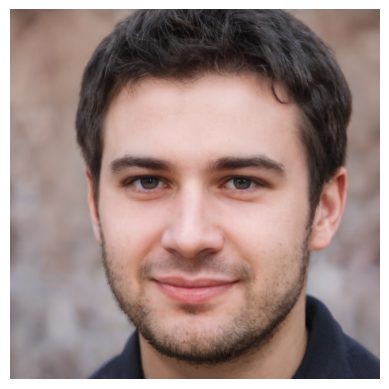

In [129]:
x = np.ravel(lat1).copy() + 5 * w_sq

# new image vector = old image vector + magnitude * direction vector
x = np.ravel(lat1).copy() + 5 * w_sq

x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

(18, 512)
(18, 512)
(18, 512)
(18, 512)
(18, 512)
(18, 512)
(18, 512)
(18, 512)
(18, 512)
(18, 512)
(18, 512)


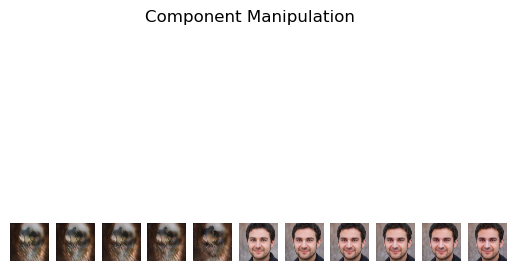

In [130]:
# Example component manipulation
steps = 10
component_index = 5
values_range = np.linspace(-2.0, 2.0, steps + 1)

manipulated_codes = []

manipulated_images = []

for value in values_range:
    manipulated_code = np.copy(lat1)
    manipulated_code.reshape((1, 18, 512))
    print(manipulated_code.shape)
    manipulated_code[component_index, :] = value

    # Generate image from manipulated code
    x = np.ravel(manipulated_code).copy()
    x = x.reshape((1, 18, 512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    
    manipulated_images.append(img)

# Display manipulated images
fig, axs = plt.subplots(1, len(manipulated_images))
fig.suptitle("Component Manipulation")

for i, image in enumerate(manipulated_images):
    axs[i].imshow(image)
    axs[i].axis('off')

plt.show()

1/1 [==============================] - 0s 103ms/step
[0.2511946]


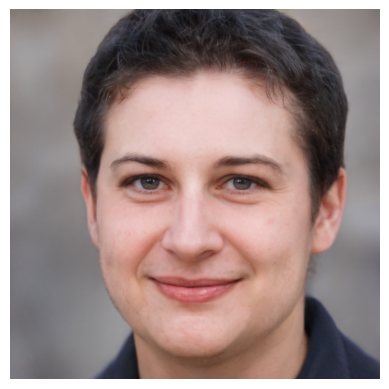

In [161]:
# Example dimension dropping
dimension_to_drop = 6

dropped_code = np.copy(lat1)
dropped_code[dimension_to_drop, :] = 0

# Generate image from dropped code
x = np.ravel(dropped_code).copy()
x = x.reshape((1, 18, 512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))

# Display the dropped image
plt.imshow(img)
# plt.title("Dimension Dropping")
plt.axis('off')
plt.show()

In [132]:
print(w_sq.shape)
reshaped = w_sq.reshape((18,512))
are_equal = np.all(reshaped[1:] == reshaped[:-1], axis=0)
print(np.all(are_equal))

(9216,)
True


1/1 [==============================] - 0s 87ms/step
[0.32810938]
1/1 [==============================] - 0s 89ms/step
[0.32402018]
1/1 [==============================] - 0s 87ms/step
[0.291603]


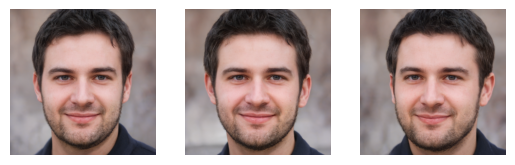

In [133]:
# Example texture synthesis
texture_components = [1, 1, 1]  # Components associated with texture details

texture_images = []
for component_index in texture_components:
    texture_code = np.copy(lat1)
    texture_code[component_index, :] = np.random.randn(1, 1, 512)  # Randomize the component

    # Generate image from texture code
    x = np.ravel(texture_code).copy()
    x = x.reshape((1, 18, 512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))

    texture_images.append(img)

# Display texture images
fig, axs = plt.subplots(1, len(texture_images))
# fig.suptitle("Texture Synthesis")

for i, image in enumerate(texture_images):
    axs[i].imshow(image)
    axs[i].axis('off')

plt.show()


1/1 [==============================] - 0s 91ms/step
[0.4148803]
1/1 [==============================] - 0s 86ms/step
[0.54488206]
1/1 [==============================] - 0s 87ms/step
[0.958578]


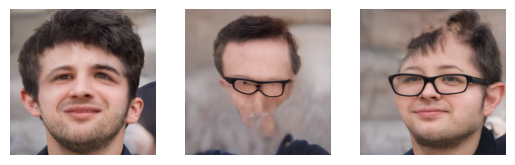

In [134]:
# Example texture synthesis
component_number = 2
texture_components = [component_number, component_number, component_number]  # Components associated with texture details

texture_images = []
random_array = []
for component_index in texture_components:
    texture_code = np.copy(lat1)
    # texture_code[component_index, :] = np.random.randn(1, 1, 512)  # Randomize the component
    texture_code[component_index, :] = np.random.uniform(-5, 5, size=(1,1,512)) # Randomize the component
    #print(texture_code[component_index])
    random_array.append(texture_code[component_index])

    # Generate image from texture code
    x = np.ravel(texture_code).copy()
    x = x.reshape((1, 18, 512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))

    texture_images.append(img)

# Display texture images
fig, axs = plt.subplots(1, len(texture_images))
# fig.suptitle("Texture Synthesis")

for i, image in enumerate(texture_images):
    axs[i].imshow(image)
    axs[i].axis('off')

plt.show()


In [135]:
glasses_possible = []

In [136]:
glasses_possible.append(random_array[0])

In [137]:
print(glasses_possible[0])

[ 2.4907103e+00 -3.2411504e+00 -4.3991513e+00  2.7305088e+00
 -3.4318533e+00  1.0231720e-01  1.1845866e+00  4.9716510e-02
 -1.1124175e-01 -1.2332370e+00  1.5905286e+00 -3.4388332e+00
  4.3021560e+00 -4.4218450e+00  2.5153725e+00  9.0101406e-02
 -4.8412204e+00  1.1099360e+00  3.4320879e-01 -2.0149711e-01
 -6.3950205e-01  3.2588332e+00 -3.4828668e+00  2.7218933e+00
  4.9738498e+00 -3.6965554e+00 -1.3017993e+00  4.2505598e+00
 -2.4910443e+00 -1.3784615e+00 -1.9778118e+00 -1.1820947e+00
 -4.0234318e+00 -2.1903212e+00 -4.0895381e+00  3.1930783e+00
  2.2859266e+00  3.3443220e+00  2.1112099e+00  1.1009973e+00
  3.5293589e+00 -1.0934179e+00  1.3737680e+00 -3.3386688e+00
 -3.3134701e+00  6.1231613e-01  2.8468263e+00 -4.0349364e+00
 -3.2429216e+00 -3.7395360e+00  4.5325646e+00 -1.2793599e+00
  3.8140662e+00 -3.3986170e+00  3.4763269e+00  3.3618963e+00
 -3.6299207e+00 -1.7892004e+00 -3.5215521e-01 -2.8090706e+00
 -6.0466260e-01 -3.6672065e+00  1.5838506e+00 -1.0563797e+00
 -8.0926812e-01  1.49499

In [138]:
from sklearn.preprocessing import MinMaxScaler

N = len(glasses_possible)
array_size = glasses_possible[0].shape[0]
array_list = glasses_possible.copy()

# Set a threshold for high and low values
high_threshold = 0.15  # Adjust as needed
low_threshold = 0.7  # Adjust as needed

# Scale the ndarrays to the range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_arrays = [scaler.fit_transform(array.reshape(-1, 1)).flatten() for array in array_list]
# print(scaled_arrays[0])

# Create an array to store the boolean mask indicating common indexes
common_indexes = np.ones(array_size, dtype=bool)

# Iterate over each scaled ndarray
for array in scaled_arrays:
    # Find the indexes that meet the high and low thresholds
    high_indexes = np.where(array > high_threshold)[0]
    low_indexes = np.where(array < low_threshold)[0]

    # Update the common indexes mask
    common_indexes &= np.in1d(np.arange(array_size), high_indexes) & np.in1d(np.arange(array_size), low_indexes)

# Find the common indexes that are True for all arrays
common_indexes = np.where(common_indexes)[0]

# Print the common indexes
print("Common indexes:")
print(common_indexes)

Common indexes:
[  1   4   5   6   7   8   9  10  11  15  17  18  19  20  26  28  29  30
  31  33  39  41  42  43  44  45  48  51  53  57  58  59  60  62  63  64
  65  67  70  76  77  80  81  82  83  87  89  90  91  92  94  95  97  98
 101 103 104 107 109 112 113 114 115 116 118 119 121 122 124 126 127 129
 130 132 134 137 139 140 142 144 146 153 154 157 158 159 160 161 162 163
 164 167 168 171 172 173 175 177 179 180 182 190 193 195 196 199 201 202
 204 206 208 210 211 213 214 215 217 218 219 220 222 223 225 228 229 231
 232 234 236 238 239 244 246 250 251 252 254 255 257 258 260 261 264 265
 266 268 269 271 272 281 285 288 289 290 294 295 298 300 301 302 304 305
 306 307 308 309 311 314 315 316 317 319 320 323 324 325 329 331 335 336
 337 338 339 340 344 346 348 349 352 353 354 355 358 366 367 368 369 373
 375 376 377 378 384 385 387 389 390 392 394 396 397 398 399 400 401 402
 403 406 409 410 414 415 416 419 420 422 423 424 425 426 429 433 435 439
 440 441 444 445 447 448 449 452 45

0.16239451
0.41985548


1/1 [==============================] - 0s 88ms/step
[0.34919485]


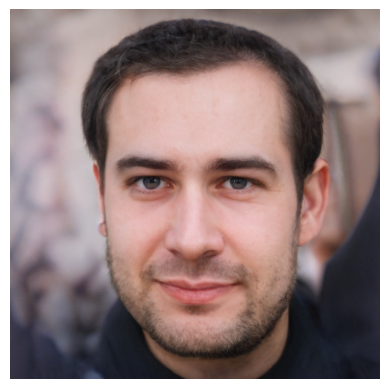

In [139]:
# Example texture synthesis
component_number = 2
texture_components = [component_number]  # Components associated with texture details

texture_images = []
for component_index in texture_components:
    texture_code = np.copy(lat1)
    vector = texture_code[component_index]
    print(np.mean(vector))
    print(np.std(vector))
    # texture_code[component_index, :] = np.random.randn(1, 1, 512)  # Randomize the component
    # texture_code[component_index, :] = np.random.uniform(-10, 10, size=(1,1,512)) # Randomize the component
    # texture_code[component_index, 24] = 80
    texture_code[component_index, :] += 15
    # print(texture_code[component_index])

    # Generate image from texture code
    x = np.ravel(texture_code).copy()
    x = x.reshape((1, 18, 512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((1,224,224,3))
    x = assessor_2.predict(sample)[0]
    print(calc_mem(x))

    texture_images.append(img)

# Display the dropped image
plt.imshow(img)
# plt.title("Dimension Dropping")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 88ms/step
[0.58341193]


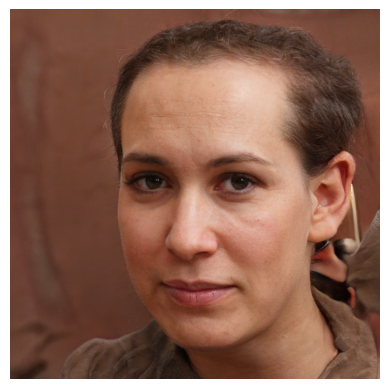

In [140]:
# Example dimension dropping
dimension_to_drop = 2

dropped_code = np.copy(X_test[60]).reshape((18, 512))
dropped_code[dimension_to_drop, :] = 16

# Generate image from dropped code
x = np.ravel(dropped_code).copy()
x = x.reshape((1, 18, 512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))

# Display the dropped image
plt.imshow(img)
# plt.title("Dimension Dropping")
plt.axis('off')
plt.show()

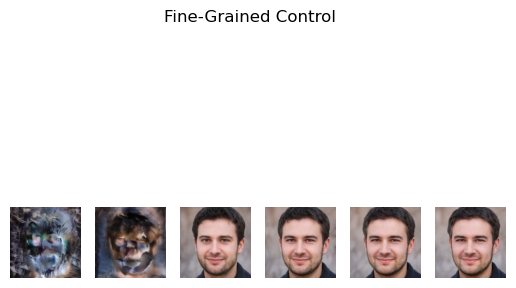

In [141]:
# Example fine-grained control (not using)
steps = 5
component_index = 7
fine_grained_values = np.linspace(-1.0, 1.0, steps + 1)

fine_grained_images = []
for value in fine_grained_values:
    fine_grained_code = np.copy(lat1)
    fine_grained_code[component_index, :] += value

    # Generate image from fine-grained code
    x = np.ravel(fine_grained_code).copy()
    x = x.reshape((1, 18, 512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]

    fine_grained_images.append(img)

# Display fine-grained control images
fig, axs = plt.subplots(1, len(fine_grained_images))
fig.suptitle("Fine-Grained Control")

for i, image in enumerate(fine_grained_images):
    axs[i].imshow(image)
    axs[i].axis('off')

plt.show()

### Making trait score models

In [142]:
scores = []
images = []
print(3000*31)

trait = smile

# size will be loops * 31
for i in range(50):
    x = X_test[i].copy()
    cur_image = x

    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    sample = load_image(img)
    sample = sample.reshape((224,224,3))

    scores.append(0)
    images.append(sample)

    # positive direction
    for b in range(10):
        if b == 3 or b == 6 or b == 9:
            x = cur_image + b * trait

            x = x.reshape((1,18,512))
            out = generator.synthesis_network(x)
            img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
            img = img.numpy()[0]
            sample = load_image(img)
            sample = sample.reshape((224,224,3))

            scores.append(b)
            images.append(sample)

    # negative direction
    for b in range(10):
        if b == 3 or b == 6 or b == 9:
            x = cur_image - b * trait

            x = x.reshape((1,18,512))
            out = generator.synthesis_network(x)
            img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
            img = img.numpy()[0]
            sample = load_image(img)
            sample = sample.reshape((224,224,3))

            scores.append(-b)
            images.append(sample)

X_train_trait = np.array(images)
y_train_trait = np.array(scores)

X_train_trait, X_test_trait, y_train_trait, y_test_trait = train_test_split(X_train_trait, y_train_trait, test_size=0.2, random_state=42)

93000


In [143]:
print(images[0].shape)

(224, 224, 3)


In [144]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(224, 224, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(11)
])

model.compile(optimizer='adam', loss='mse')

In [145]:
model.fit(X_train_trait, y_train_trait, epochs=10)

Epoch 1/10
9/9 [==============================] - 1s 52ms/step - loss: 79132160.0000
Epoch 2/10
9/9 [==============================] - 0s 55ms/step - loss: 36.2571
Epoch 3/10
9/9 [==============================] - 0s 54ms/step - loss: 36.2571
Epoch 4/10
9/9 [==============================] - 1s 56ms/step - loss: 36.2571
Epoch 5/10
9/9 [==============================] - 0s 52ms/step - loss: 36.2571
Epoch 6/10
9/9 [==============================] - 0s 52ms/step - loss: 36.2571
Epoch 7/10
9/9 [==============================] - 0s 52ms/step - loss: 36.2571
Epoch 8/10
9/9 [==============================] - 0s 52ms/step - loss: 36.2571
Epoch 9/10
9/9 [==============================] - 0s 55ms/step - loss: 36.2571
Epoch 10/10
9/9 [==============================] - 0s 52ms/step - loss: 36.2571


In [146]:
loss = model.evaluate(X_test_trait, y_test_trait, verbose=2)
print(f"Loss: {loss}")

3/3 - 0s - loss: 35.1511 - 184ms/epoch - 61ms/step
Loss: 35.15107727050781


In [147]:
model.save("smile_model.h5")

In [148]:
smile_assessor = tf.keras.models.load_model('smile_model.h5', custom_objects={'euclidean_distance_loss': euclidean_distance_loss})

In [149]:
x = X_test[68].copy() - 0 * width
x = x.reshape((1,18,512))
print(x.shape)
print(x.shape[1])

(1, 18, 512)
18


In [150]:
test_notmean_w_sq = test_notmean_w_sq.reshape((1,18,512))
print(test_notmean_w_sq[0,17,:]==test_notmean_w_sq[0,5,:])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

(1024, 1024, 3)
1/1 [==============================] - 0s 87ms/step
Mem Assessor: [0.4127756]
1/1 [==============================] - 0s 59ms/step
Smile Assessor: [ 0.00296805  0.00388341  0.00393512 -0.00758656 -0.00963379 -0.00392258
 -0.00254412  0.0038882   0.00402442  0.00588183 -0.00276546]


(-0.5, 1023.5, 1023.5, -0.5)

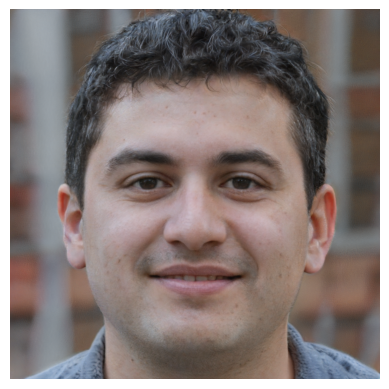

In [151]:
x = X_test[68].copy() - 10 * width
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
print(img.shape)
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
m = assessor_2.predict(sample)[0]
print(f"Mem Assessor: {calc_mem(m)}")
x = smile_assessor.predict(sample)[0]
print(f"Smile Assessor: {x}")
plt.imshow(img)
plt.axis('off')

In [152]:
"""
from tensorflow import keras

# Step 3: Design the model architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1024,1024,3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='linear')  # Assuming age is a continuous trait
])

# Step 4: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the model
model.fit(X_train_trait, y_train_trait, batch_size=32, epochs=10, validation_data=(X_test_trait, y_test_trait))

# Step 6: Evaluate the model
loss = model.evaluate(X_test_trait, y_test_trait)
print("Test loss:", loss)

# Step 9: Deploy and use the trained model
model.save('smile.h5')
"""

'\nfrom tensorflow import keras\n\n# Step 3: Design the model architecture\nmodel = keras.Sequential([\n    keras.layers.Conv2D(32, (3, 3), activation=\'relu\', input_shape=(1024,1024,3)),\n    keras.layers.MaxPooling2D((2, 2)),\n    keras.layers.Flatten(),\n    keras.layers.Dense(64, activation=\'relu\'),\n    keras.layers.Dense(1, activation=\'linear\')  # Assuming age is a continuous trait\n])\n\n# Step 4: Compile the model\nmodel.compile(optimizer=\'adam\', loss=\'mean_squared_error\')\n\n# Step 5: Train the model\nmodel.fit(X_train_trait, y_train_trait, batch_size=32, epochs=10, validation_data=(X_test_trait, y_test_trait))\n\n# Step 6: Evaluate the model\nloss = model.evaluate(X_test_trait, y_test_trait)\nprint("Test loss:", loss)\n\n# Step 9: Deploy and use the trained model\nmodel.save(\'smile.h5\')\n'

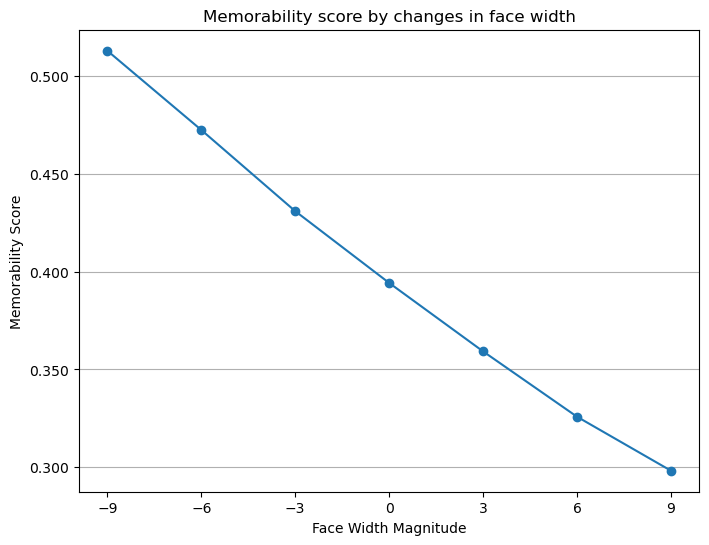

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Data
values = [0.5129, 0.4724, 0.4309, 0.3942, 0.3592, 0.3258, 0.2982]
labels = [-9, -6, -3, 0, 3, 6, 9]

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(labels, values, marker='o')


# Add labels and title
plt.xlabel('Face Width Magnitude')
plt.ylabel('Memorability Score')
plt.title('Memorability score by changes in face width')

# Set x-axis ticks to match the labels
plt.xticks(labels)

# Improve y-axis formatting
plt.gca().yaxis.grid(True)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))  # Display y-axis with 3 decimal places

# Save the plot as an image
# plt.savefig('data_plot.png', dpi=300)  # Adjust dpi for higher resolution if needed

# Show the plot (optional)
plt.show()

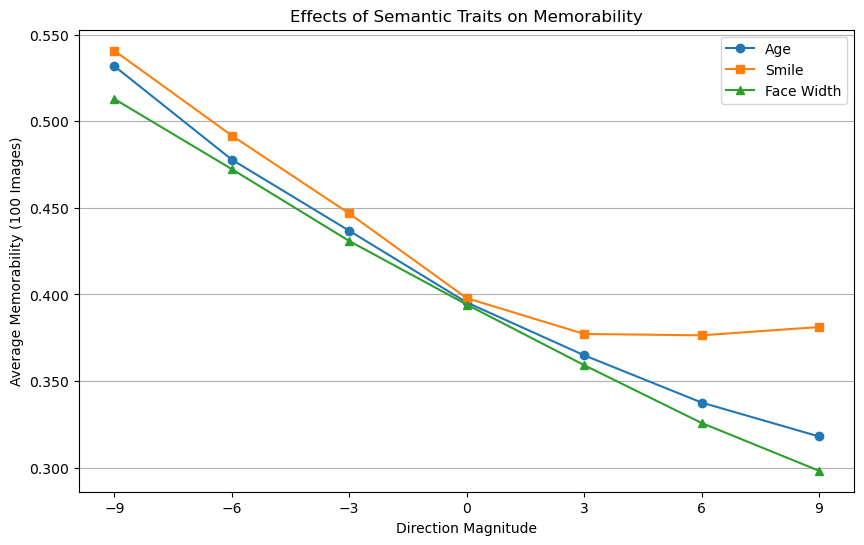

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Data for three sets
values_set1 = [0.5319, 0.4779, 0.4368, 0.3954, 0.3649, 0.3376, 0.3180]
values_set2 = [0.5408, 0.4918, 0.4468, 0.3979, 0.3772, 0.3764, 0.3812]
values_set3 = [0.5129, 0.4724, 0.4309, 0.3942, 0.3592, 0.3258, 0.2982]
labels = [-9, -6, -3, 0, 3, 6, 9]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the three sets of values
plt.plot(labels, values_set1, marker='o', label='Age')
plt.plot(labels, values_set2, marker='s', label='Smile')
plt.plot(labels, values_set3, marker='^', label='Face Width')

# Add labels and title
plt.xlabel('Direction Magnitude')
plt.ylabel('Average Memorability (100 Images)')
plt.title('Effects of Semantic Traits on Memorability')

# Set x-axis ticks to match the labels
plt.xticks(labels)

# Improve y-axis formatting
plt.gca().yaxis.grid(True)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Add legend
plt.legend()

# Save the plot as an image
#plt.savefig('data_plot.png', dpi=300)

# Show the plot (optional)
plt.show()

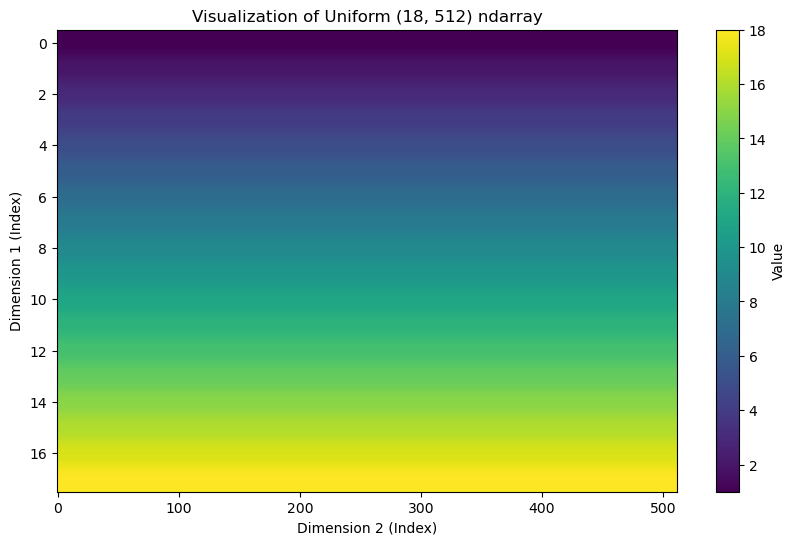

In [155]:
import numpy as np
import matplotlib.pyplot as plt

shape = (18, 512)

# Create a uniform array where each row is the same
uniform_data = np.ones(shape) * np.arange(1, shape[0] + 1)[:, np.newaxis]

plt.figure(figsize=(10, 6))
plt.imshow(uniform_data, cmap='viridis', aspect='auto')  # Use a colormap (e.g., 'viridis')
plt.colorbar(label='Value')  # Add a colorbar indicating values
plt.xlabel('Dimension 2 (Index)')
plt.ylabel('Dimension 1 (Index)')
plt.title('Visualization of Uniform (18, 512) ndarray')
plt.show()

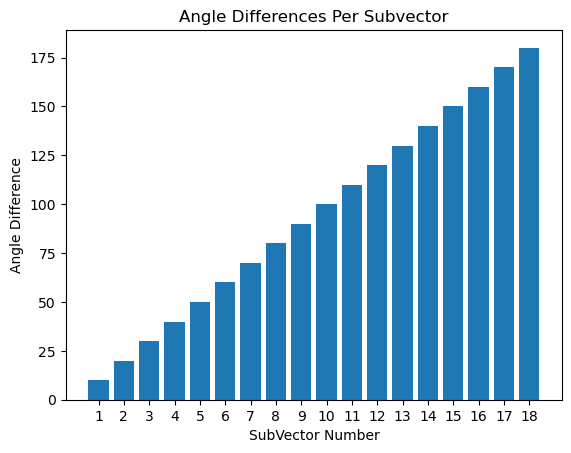

In [156]:
import matplotlib.pyplot as plt

# Your array of angle differences
angle_differences = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]

# Create the bar graph
plt.bar(range(1, len(angle_differences) + 1), angle_differences, tick_label=range(1, len(angle_differences) + 1))

# Add labels and title
plt.xlabel('SubVector Number')
plt.ylabel('Angle Difference')
plt.title('Angle Differences Per Subvector')

# Show the graph
plt.show()